In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Параметры модели

In [3]:
# periods of repetition we're going to search for
CAPSULES = np.array([1, 4, 8, 16, 32, 48, 64, 96, 128])

# time (binary coded) as additional input 
TIME_AS_INPUT_SIZE = 6

# number of voices in polyphonic sampling scheme
VOICES = 5

In [4]:
# Network Parameters
num_input = 12 + TIME_AS_INPUT_SIZE         # dimension of one input at moment
num_hidden_local = 24                     
num_hidden_aggreg = 130                     # dimension of aggregation layer
num_hidden_voicegen = 100                   # dimension of voices generation layer
num_output = 12                             # output dimension for each voice

num_hidden_decoder = 100                    # dimension of decoder LSTM
num_decoder_output = 88                     # dimension of decoder output
num_decoder_rbm_hidden = 36                 # dimension of decoder rbm hidden layer
rbm_k = 1

## Модель

In [67]:
class LatencyLSTM(nn.Module):
    def __init__(self, latency=1):
        super(LatencyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(num_input, num_hidden_local)
        self.latency = latency
    
    def init_hidden(self, batch_size, history_init=None):
        self.t = 0
        self.hidden = [(Variable(torch.zeros(1, batch_size, num_hidden_local)),
                        Variable(torch.zeros(1, batch_size, num_hidden_local))) for _ in range(self.latency)]
    
    def forward(self, x):        
        x, self.hidden[self.t] = self.lstm(x, self.hidden[self.t])
        self.t = (self.t + 1) % self.latency
        
        return x

In [68]:
class PolyphonySampler(nn.Module):
    def __init__(self):
        super(PolyphonySampler, self).__init__()
        
        self.lstm = nn.LSTM(num_hidden_aggreg + 2*num_output, num_hidden_voicegen)
        self.linear = nn.Linear(num_hidden_voicegen, 2*num_output)
        
    def init_hidden(self, batch_size):        
        self.hidden = []
        for i in range(VOICES):
            self.hidden.append((Variable(torch.zeros(1, batch_size, num_hidden_voicegen)),
                                Variable(torch.zeros(1, batch_size, num_hidden_voicegen))))
    
    def forward(self, x, next_x=None):
        sampled_notes = torch.zeros(1, x.size()[1], num_output)        
        sample_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_sample_p = Variable(torch.ones(1, x.size()[1], num_output))
                                
        banned_notes = torch.zeros(1, x.size()[1], num_output)       
        ban_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_ban_p = Variable(torch.ones(1, x.size()[1], num_output))
        
        self.voice_distributions = []
        self.voice_decisions = []
        
        for i in range(VOICES):
            all_input = torch.cat([x, Variable(sampled_notes), Variable(banned_notes)], dim=2)
            out, self.hidden[i] = self.lstm(all_input, self.hidden[i])
            out = self.linear(out)            
            
            coeff = (1 - torch.cat([sampled_notes, sampled_notes], dim=2)) * \
                    (1 - torch.cat([banned_notes, banned_notes], dim=2))
            out = Variable(coeff) * torch.exp(out)                       
            out = out / out.sum(2)[:,:,None]
            
            self.voice_distributions.append(out.data[0].numpy())
            
            sample_p = sample_p + neg_sample_p * out[:,:,:num_output]
            neg_sample_p = neg_sample_p * (1 - out[:,:,:num_output])
                             
            ban_p = ban_p + neg_ban_p * out[:,:,num_output:]
            neg_ban_p = neg_ban_p * (1 - out[:,:,num_output:])
            
            sample = torch.LongTensor(x.size()[1], 2*num_output).zero_()
            sample.scatter_(1, torch.multinomial(out.squeeze(0).data, 1), 1)
            
            self.voice_decisions.append(sample.numpy())
            
            if self.training:
                sample = torch.cat([(sample[:,:num_output] + sample[:,num_output:]) * next_x,
                                    (sample[:,:num_output] + sample[:,num_output:]) * (1 - next_x)], dim=1)
            
            sampled_notes[0] += sample[:,:num_output].float()
            banned_notes[0]  += sample[:,num_output:].float()
        
        return sampled_notes, sample_p*(1 - ban_p)

In [69]:
import itertools
def time_generator():
    times = [np.array(t) for t in itertools.product([0, 1], repeat=TIME_AS_INPUT_SIZE)]
    t = 0
    
    while True:
        yield torch.FloatTensor(times[t])
        t = (t + 1) % len(times)

In [106]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.capsules = [LatencyLSTM(latency) for latency in CAPSULES]
        self.aggregation_lstm = nn.LSTM(num_hidden_local * len(CAPSULES), num_hidden_aggreg)
        self.sampler = PolyphonySampler()
        
        self.init_hidden(1)
        
    def init_hidden(self, batch_size): 
        self.timer = time_generator()
        
        for capsule in self.capsules:
            capsule.init_hidden(batch_size)
        
        self.aggreg_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_aggreg)),
                             Variable(torch.zeros(1, batch_size, num_hidden_aggreg)))
        
        self.sampler.init_hidden(batch_size)
    
    def forward(self, x, next_x=None):            
        inp = torch.cat([x, Variable(self.timer.__next__())[None, None].repeat(1, x.size()[1], 1)], dim=2)
        
        capsules_out = []
        for capsule in self.capsules:
            capsules_out.append(capsule(inp))   
        
        out, self.aggreg_hidden = self.aggregation_lstm(torch.cat(capsules_out, dim=2), self.aggreg_hidden)
        
        return self.sampler(out, next_x)

In [107]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.lstm = nn.LSTM(num_output + num_decoder_output, num_hidden_decoder)  
        self.v_bias_linear = nn.Linear(num_hidden_decoder, num_decoder_output) 
        self.h_bias_linear = nn.Linear(num_hidden_decoder, num_decoder_rbm_hidden)      
        
        self.W = nn.Parameter(torch.randn(num_decoder_rbm_hidden, num_decoder_output)*1e-2) 
        
        self.init_hidden(1)
        
    def init_hidden(self, batch_size):        
        self.decoder_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_decoder)),
                               Variable(torch.zeros(1, batch_size, num_hidden_decoder)))
    
    # so it was done in one of rbm realisations...
    # seems legit, though akward.
    def sample_from_p(self, p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def free_energy(self, v, v_bias, h_bias):
        vbias_term = (v * v_bias).sum(2)
        hidden_term = (v.bmm(self.W.t()[None]) + h_bias).exp().add(1).log().sum(2)
        return (-hidden_term - vbias_term).mean()
    
    def forward(self, x, prev_x_decoded):            
        inp = torch.cat([x, prev_x_decoded], dim=2)
        
        out, self.decoder_hidden = self.lstm(inp, self.decoder_hidden) 
        
        return self.v_bias_linear(out), self.h_bias_linear(out)
    
    def sample(self, _v, v_bias, h_bias):
        v = _v
        
        for _ in range(rbm_k):
            p_h = F.sigmoid(v.bmm(self.W.t()[None]) + h_bias)
            h = self.sample_from_p(p_h)
            
            p_v = F.sigmoid(h.bmm(self.W[None]) + v_bias)
            v = self.sample_from_p(p_v)
        return v, p_v

In [108]:
def learn(model, decoder, batch_x, batch_decoded, optimizer, decoder_optimizer):
        
    model.init_hidden(batch_x.shape[1])
    decoder.init_hidden(batch_x.shape[1])
    
    model.train()
    decoder.train()
    optimizer.zero_grad()
    decoder_optimizer.zero_grad()
        
    basic_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_output)).zero_()
    decoder_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()
    voice_distributions, voice_decisions = [], []
    decoder_loss = Variable(torch.FloatTensor(1).zero_())
    
    for t in range(len(batch_x)-1):
        inp = Variable(torch.FloatTensor(batch_x[t]))[None]        
        _, basic_p[t] = model(inp, torch.LongTensor(batch_x[t+1]))
        
        decoder_inp = Variable(torch.FloatTensor(batch_x[t + 1]))[None], \
                      Variable(torch.FloatTensor(batch_decoded[t]))[None]                       
        v_bias, h_bias = decoder(*decoder_inp)
        
        v = Variable(torch.FloatTensor(batch_decoded[t+1][None]))
        v1, vp = decoder.sample(v, v_bias, h_bias)
        decoder_p[t] = vp[0]
        v1 *= Variable(torch.FloatTensor(np.tile(batch_x[t + 1][None], (1, 1, 1 + num_decoder_output // num_output))[:,:,:num_decoder_output]))
        decoder_loss += decoder.free_energy(v, v_bias, h_bias) - decoder.free_energy(v1, v_bias, h_bias)
        
        voice_distributions.append(model.sampler.voice_distributions)
        voice_decisions.append(model.sampler.voice_decisions)
        
    y = Variable(torch.FloatTensor(batch_x[1:]))
    loss = -(y * torch.log(basic_p) + (1 - y)*torch.log(1 - basic_p))
    loss_picture = loss.data.numpy()
    
    loss.sum(dim=2).mean().backward()
    (decoder_loss / (batch_x.shape[0] - 1)).backward()
    
    optimizer.step()
    decoder_optimizer.step()
   
    return loss_picture, decoder_p.data.numpy(), np.array(voice_distributions), np.array(voice_decisions)
        
def sample(model, decoder, start, decoder_start, time_limit):
    model.init_hidden(1)
    decoder.init_hidden(1)
    model.eval()
    decoder.eval()
    
    sample = [start[0]]
    decoded_sample = [decoder_start[0]]
    
    for t in range(len(start)-1):
        inp = Variable(torch.FloatTensor(start[t])[None, None])
        next_notes, _ = model(inp)
        
        decoder_inp = Variable(torch.FloatTensor(start[t+1])[None, None]), \
                      Variable(torch.FloatTensor(decoder_start[t+1])[None, None])
        decoder(*decoder_inp)
        
        sample.append(start[t+1])
        decoded_sample.append(decoder_start[t+1])
    
    next_notes = torch.FloatTensor(start[-1][None, None])
    
    while len(sample) < time_limit:
        next_notes, _ = model(Variable(next_notes))
        
        prev_decoded = Variable(torch.FloatTensor(decoded_sample[-1].astype(np.float32))[None, None])
        v_bias, h_bias = decoder(Variable(next_notes), prev_decoded)
        next_decoded, _ = decoder.sample(prev_decoded, v_bias, h_bias)
        
        sample.append(next_notes[0][0].numpy())
        
        mask = np.tile(sample[-1], (1 + num_decoder_output // num_output))[:num_decoder_output]
        decoded_sample.append(mask * next_decoded[0][0].data.numpy())
        
    return np.array(sample), np.array(decoded_sample)

## Данные

In [109]:
songs = np.load("CP_dataset.npy")

In [110]:
batch_size = 140
fragment_lentgh = 256
fragment_step = 32

In [111]:
def compress(song):    
    compressed = song[:, :12]
    for i in range(1,7):
        compressed = np.logical_or(compressed, song[:, 12*i:12*i+12])            
    return compressed

In [112]:
song_fragments = []
csong_fragments = []

for song in songs:
    csong = compress(song)
    
    for i in range(0, csong.shape[0] - fragment_lentgh, fragment_step):
        song_fragments.append(song[i:i+fragment_lentgh])
        csong_fragments.append(csong[i:i+fragment_lentgh])

song_fragments = np.array(song_fragments)
csong_fragments = np.array(csong_fragments)

In [113]:
def batchGenerator():
    while True:
        indexes = np.random.choice(np.arange(len(csong_fragments)), batch_size)
        batch_x, batch_decoded = csong_fragments[indexes], song_fragments[indexes]
                
        to_roll = np.random.randint(-6, 6)
        if to_roll > 0:
            batch_decoded[:, :, -to_roll:] = 0
        else:
            batch_decoded[:, :, :-to_roll] = 0

        batch_x = np.roll(batch_x, to_roll, axis=2)
        batch_decoded = np.roll(batch_decoded, to_roll, axis=2)
        
        yield np.moveaxis(batch_x, 1, 0).astype(np.float32), \
              np.moveaxis(batch_decoded, 1, 0).astype(np.float32)

### Графика

In [114]:
def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

# Обучение

In [115]:
model = Model()
decoder = Decoder()

In [116]:
#model.load_state_dict(torch.load("capsules - model.pt"))
#decoder.load_state_dict(torch.load("capsules - decoder.pt"))

In [119]:
#losses = []
#decoder_losses = []

0.163009


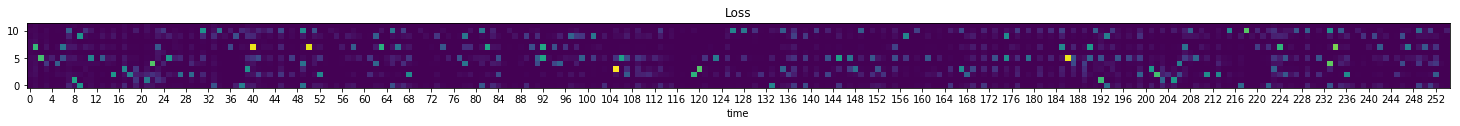

0.163453


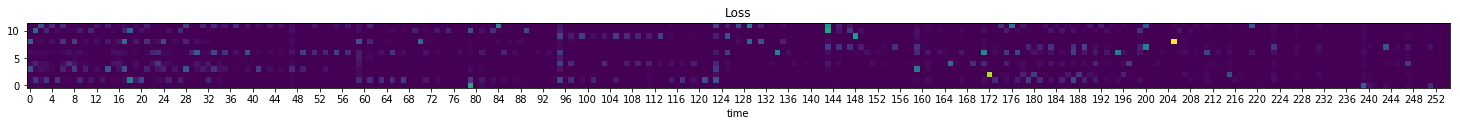

0.156444


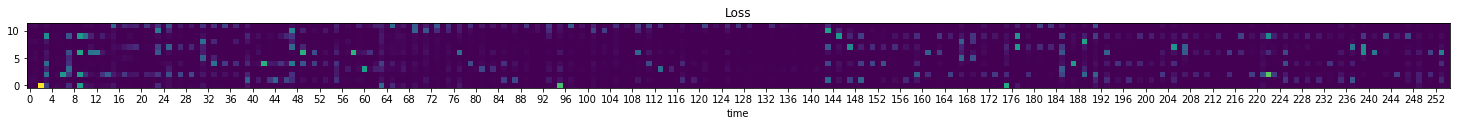

0.157152


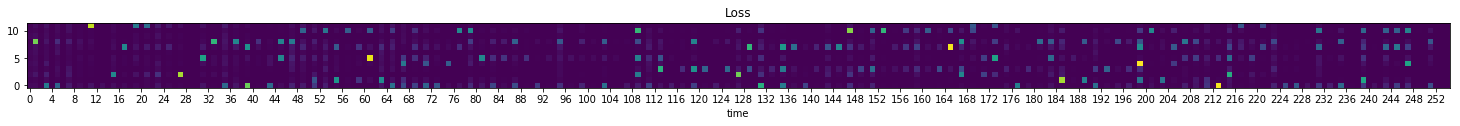

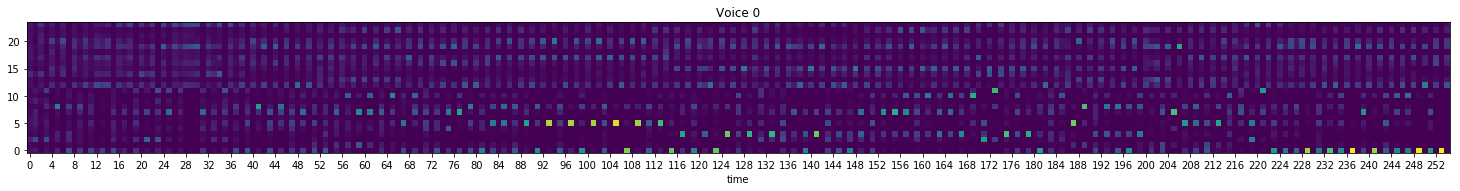

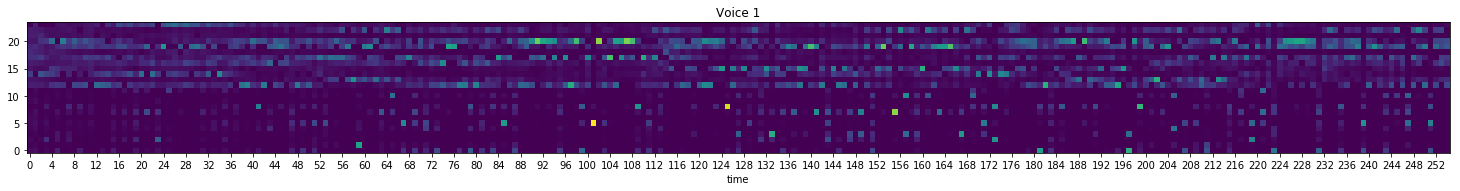

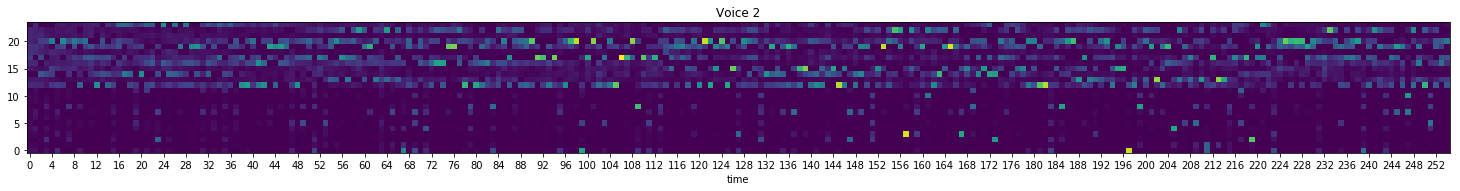

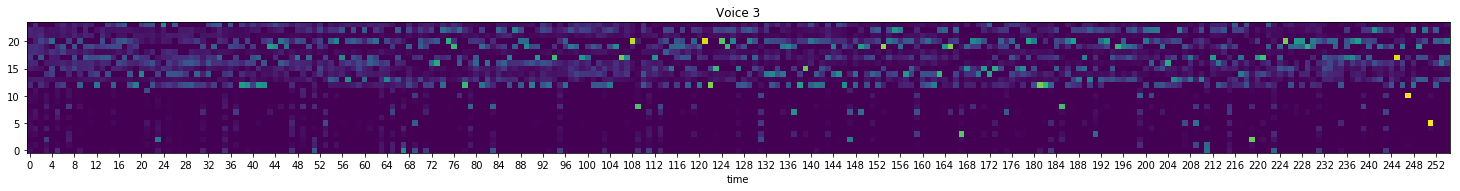

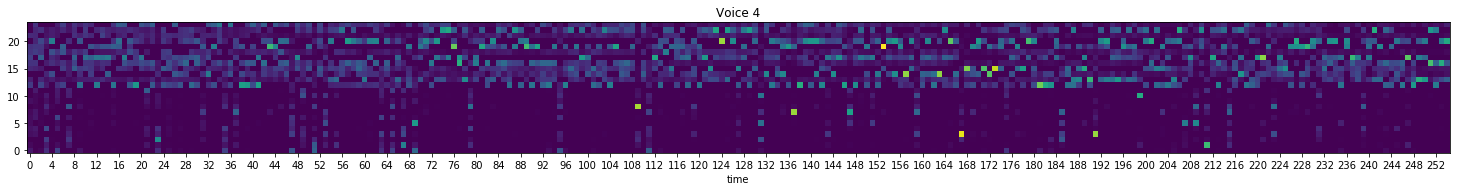

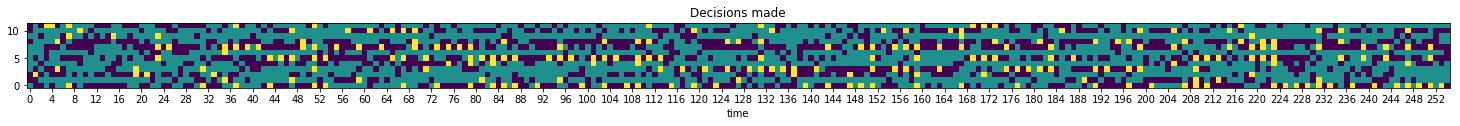

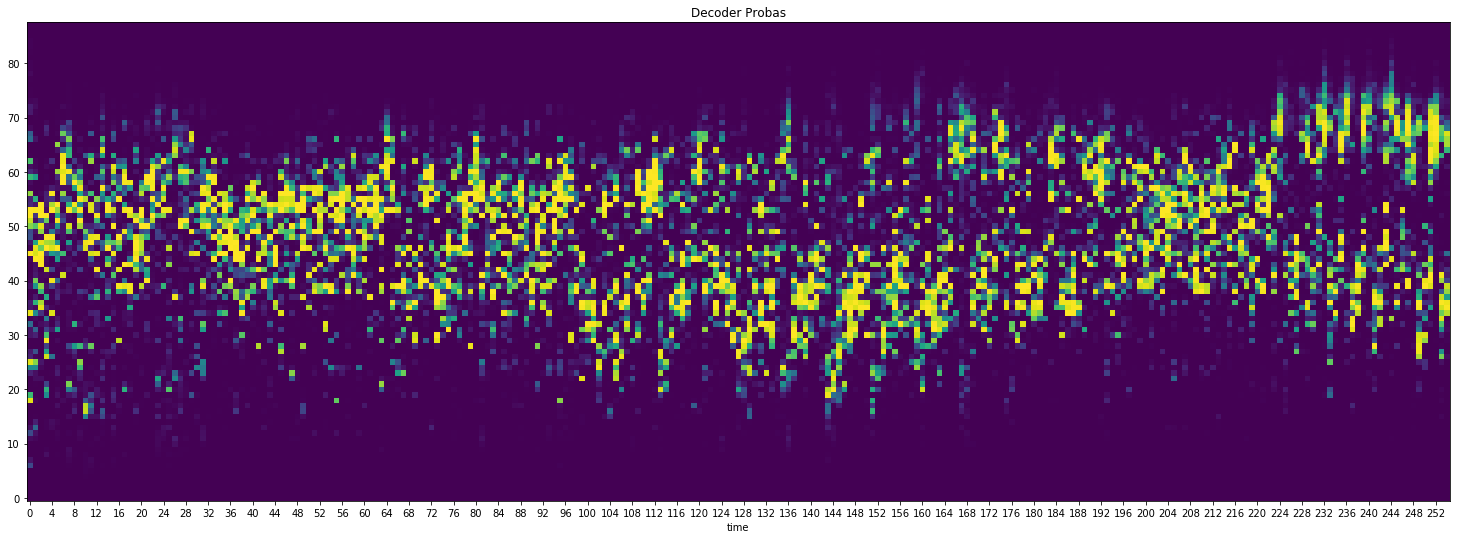

0.167391


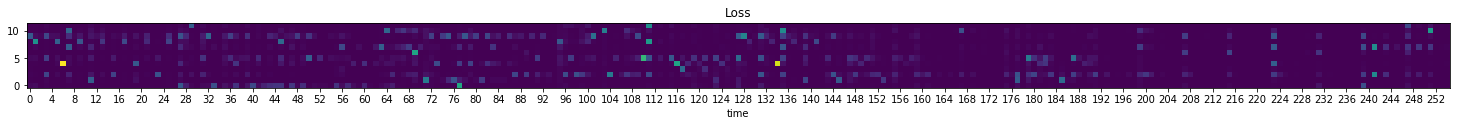

0.160028


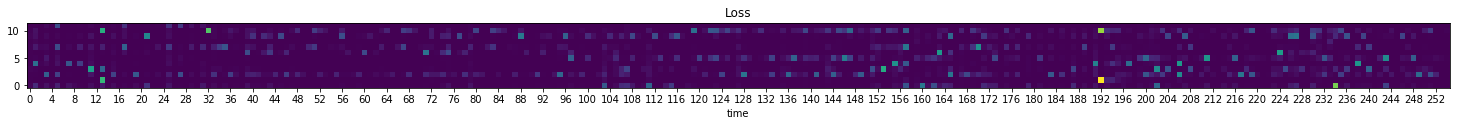

0.152639


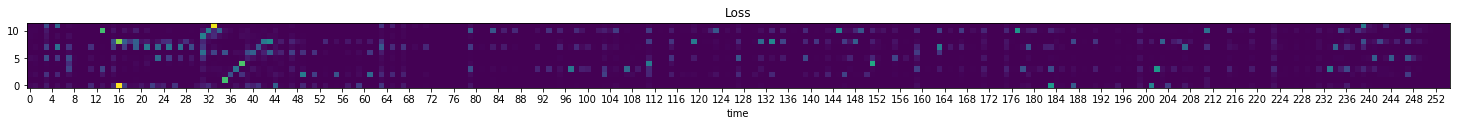

0.159238


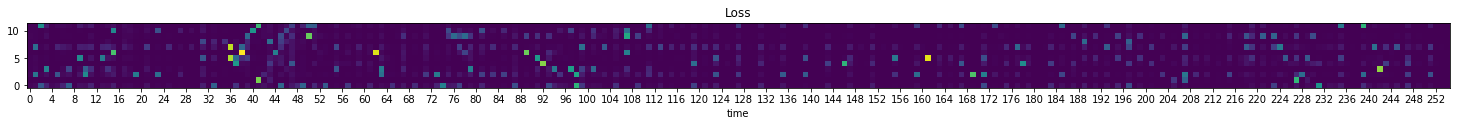

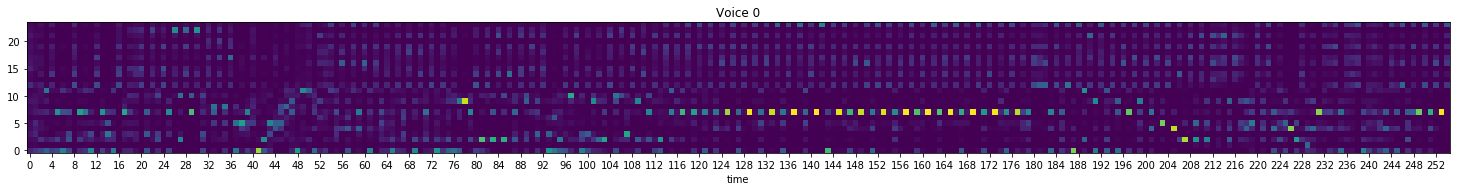

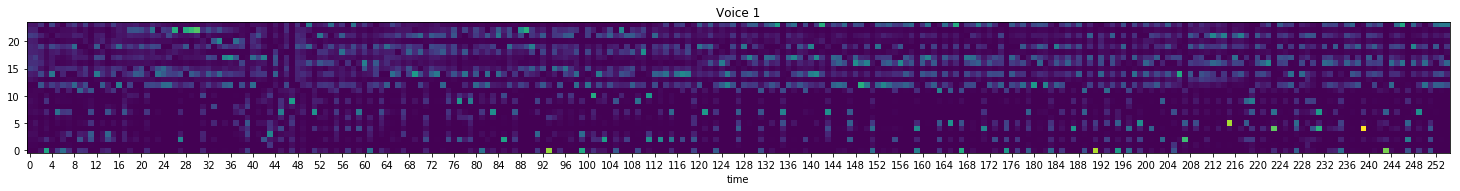

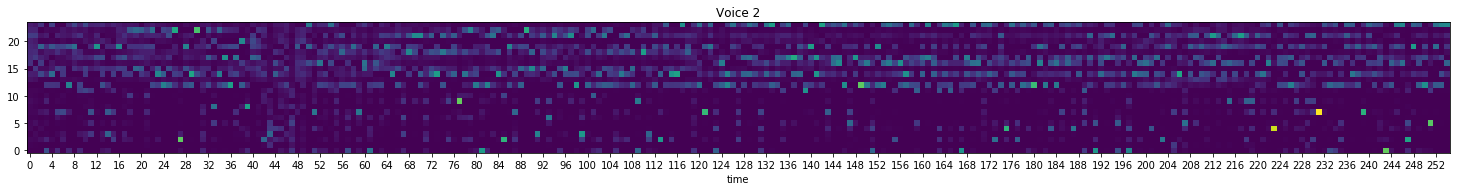

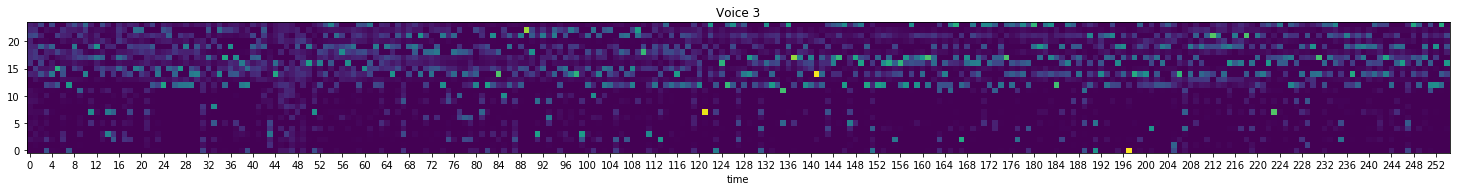

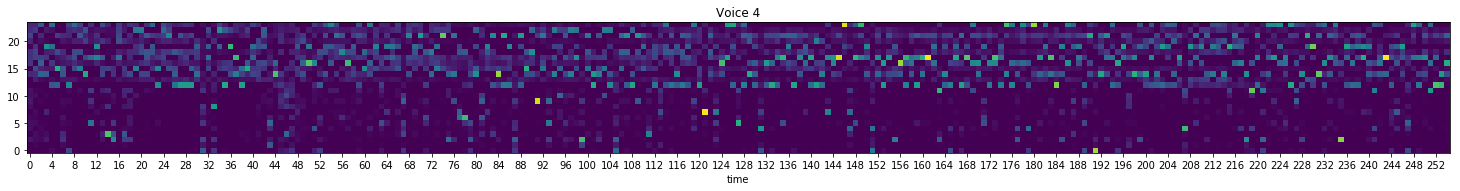

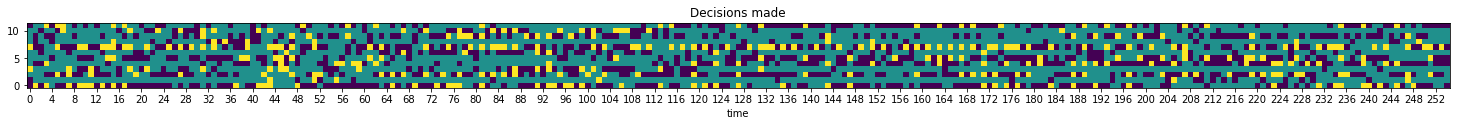

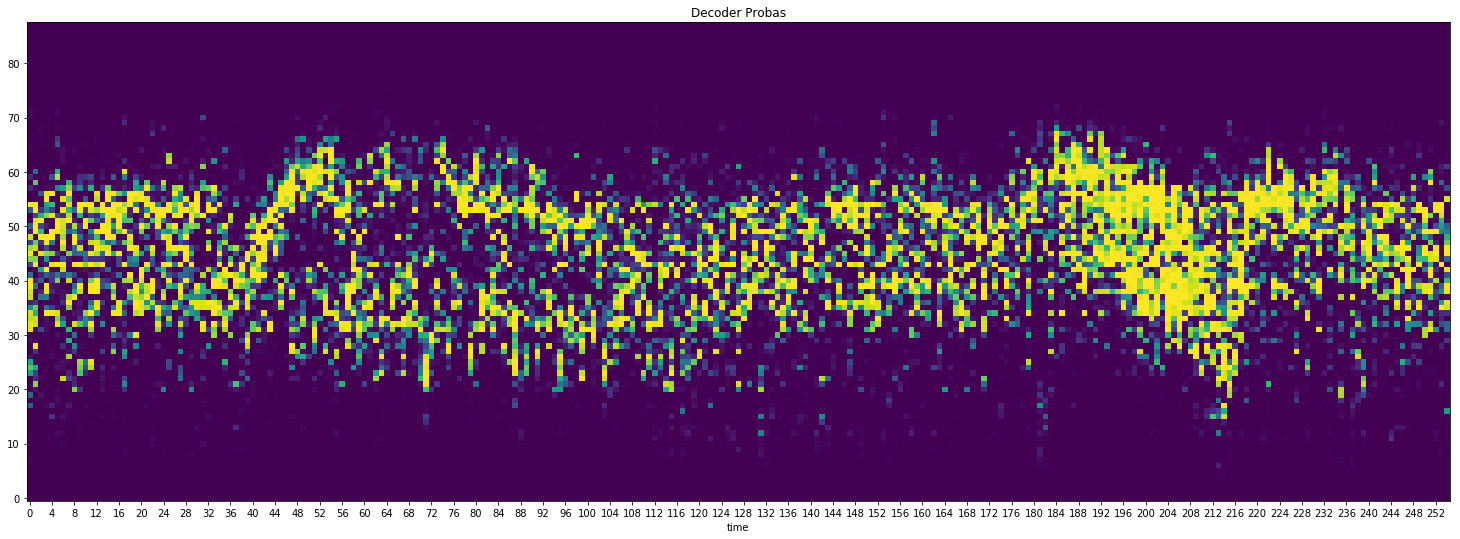

0.155496


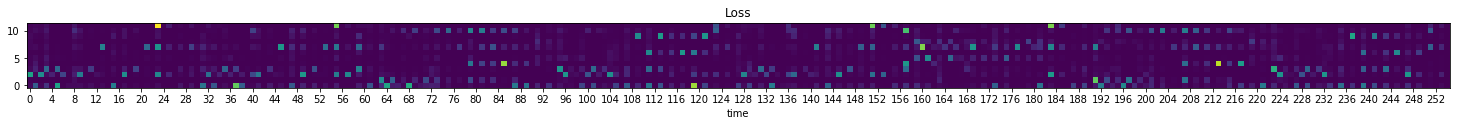

0.161012


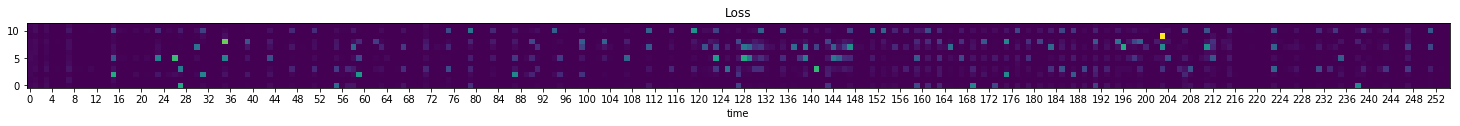

0.155265


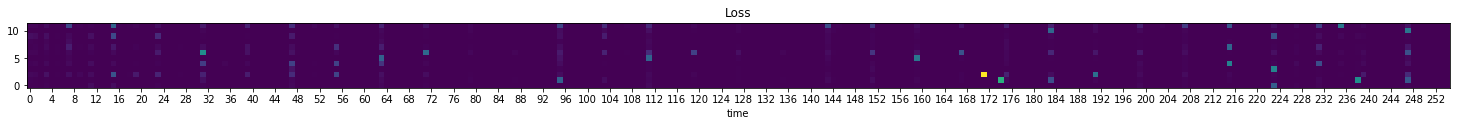

0.160253


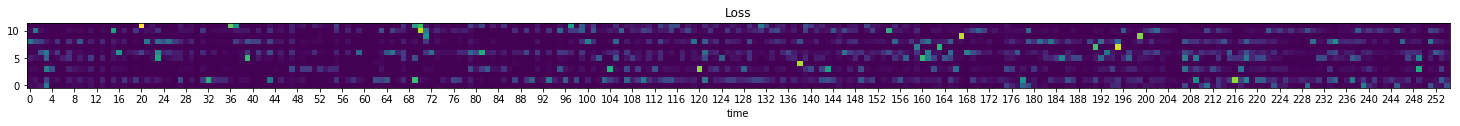

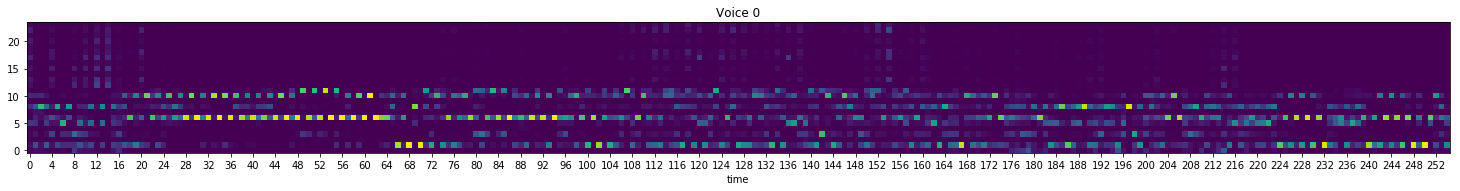

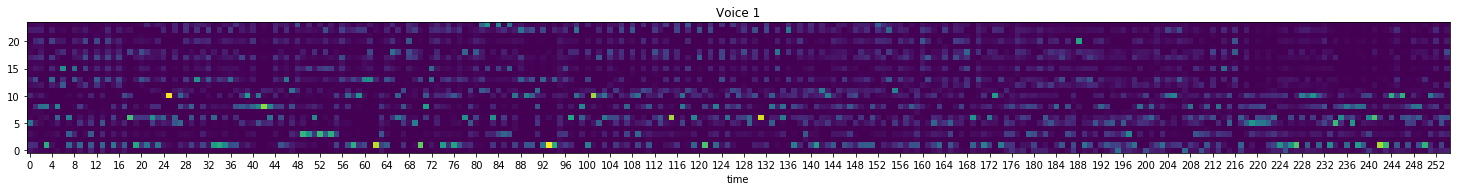

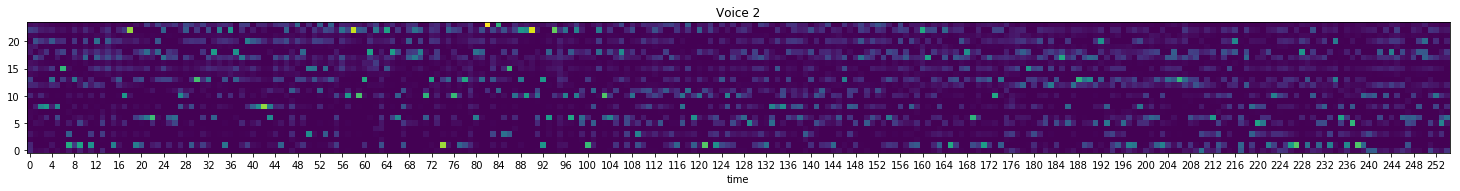

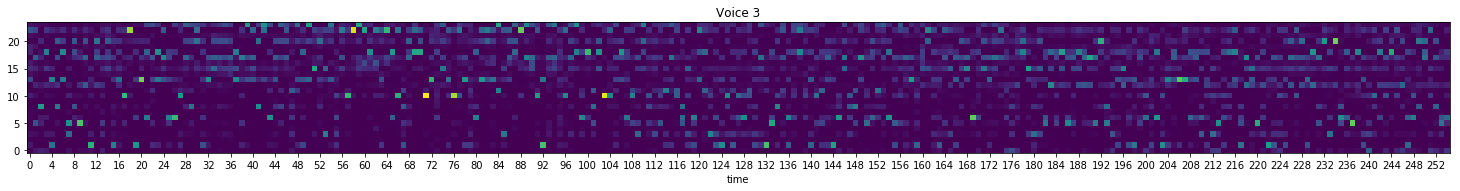

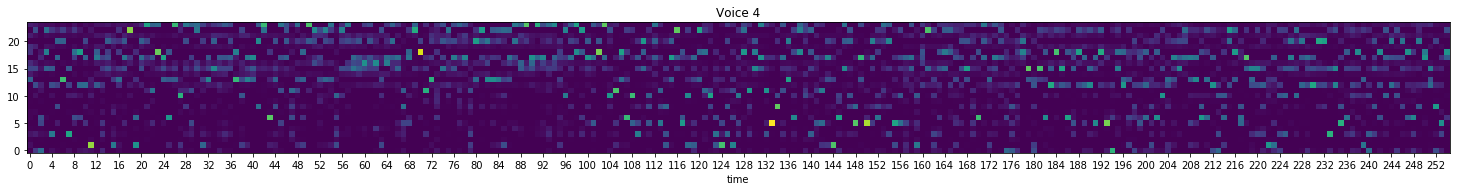

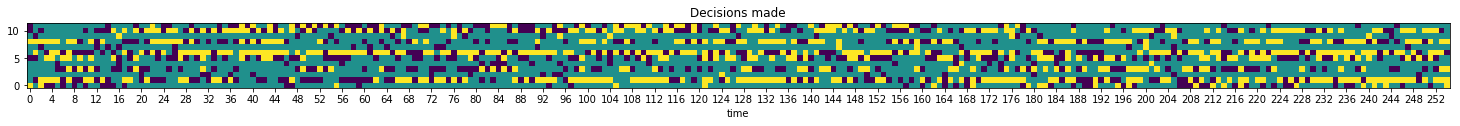

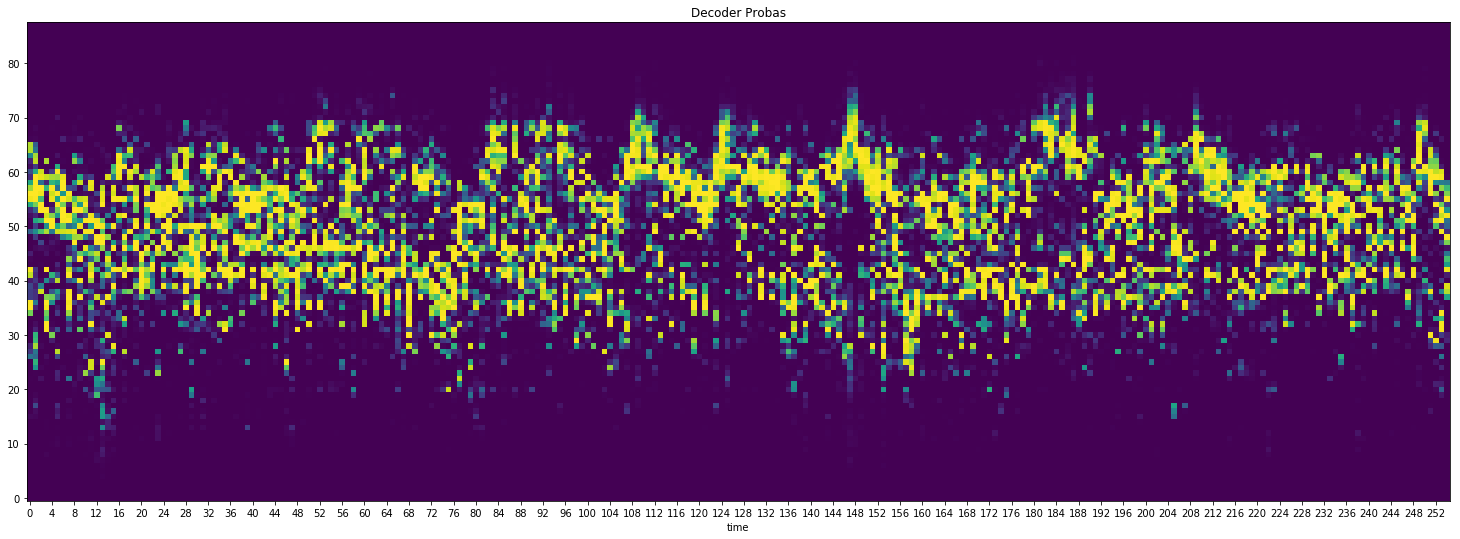

0.163976


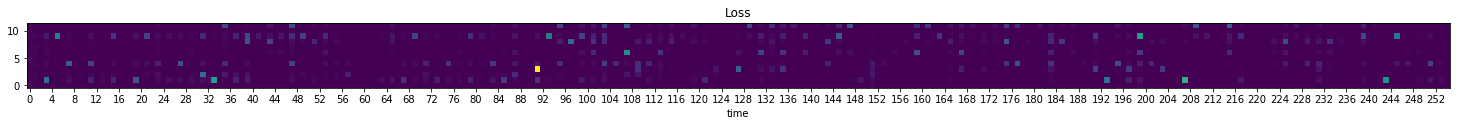

0.152205


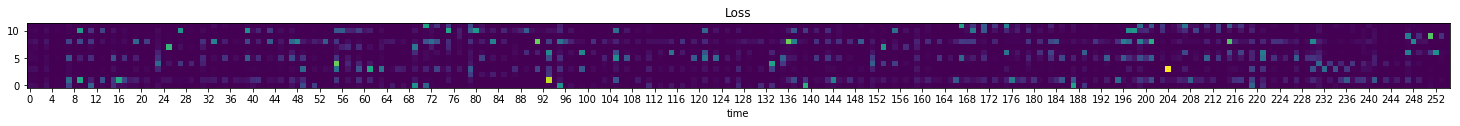

0.171076


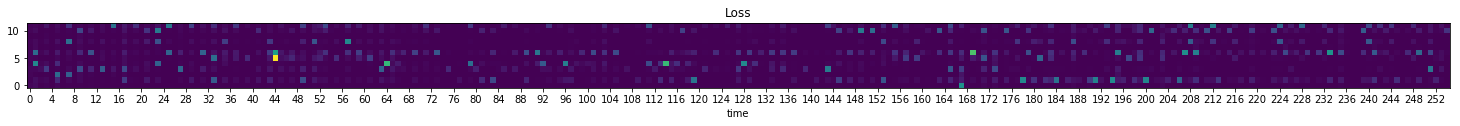

0.1604


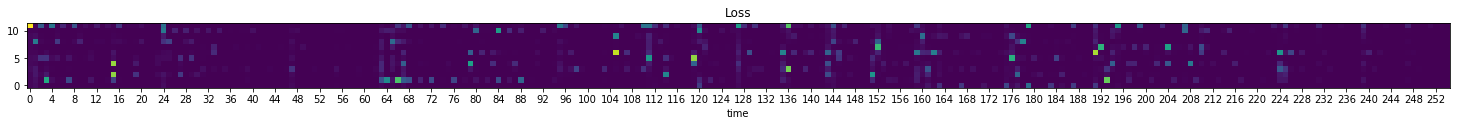

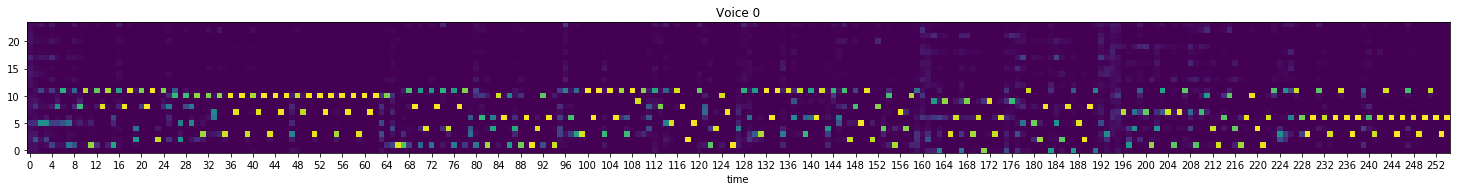

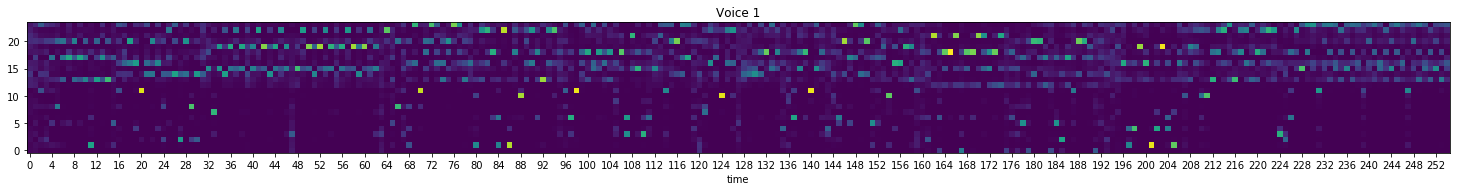

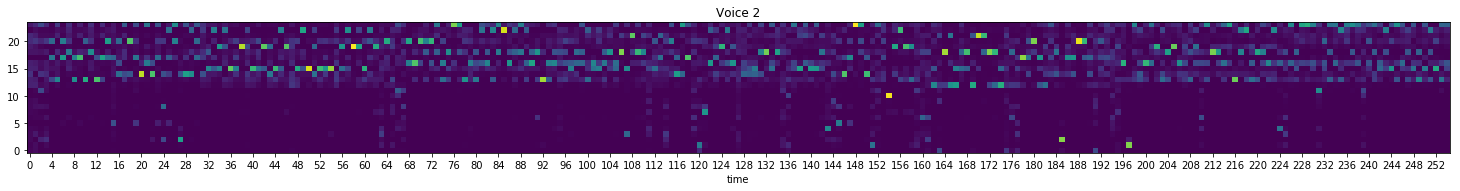

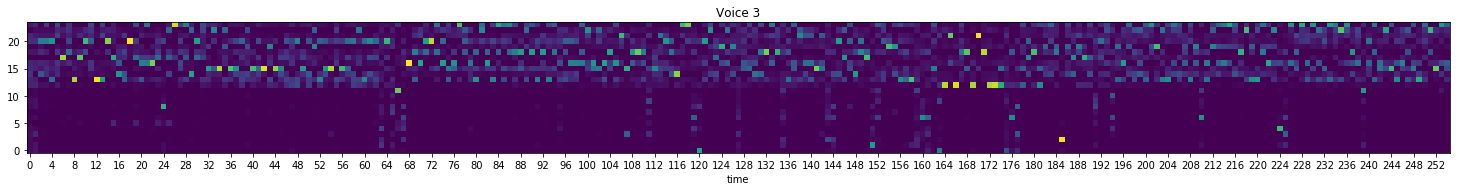

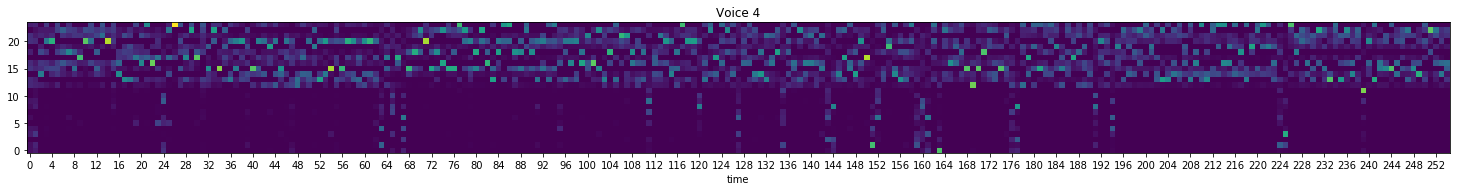

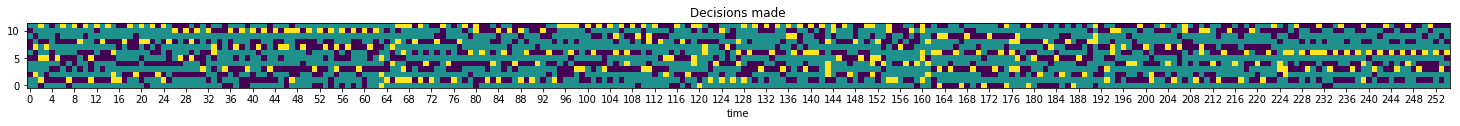

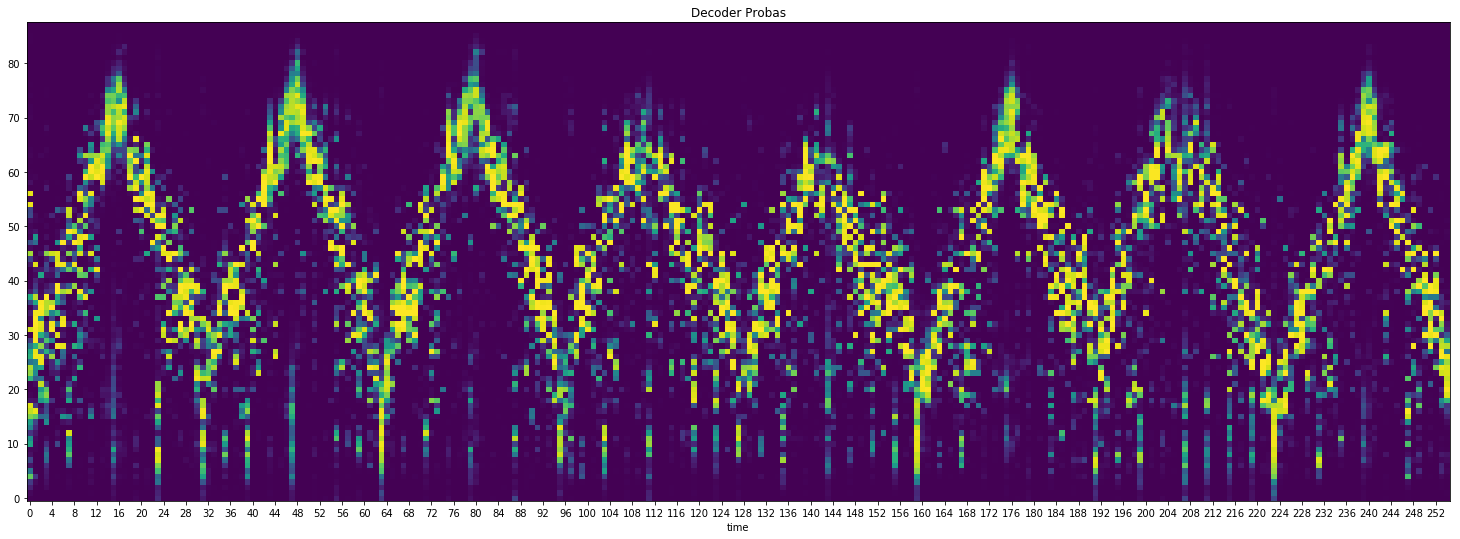

0.164566


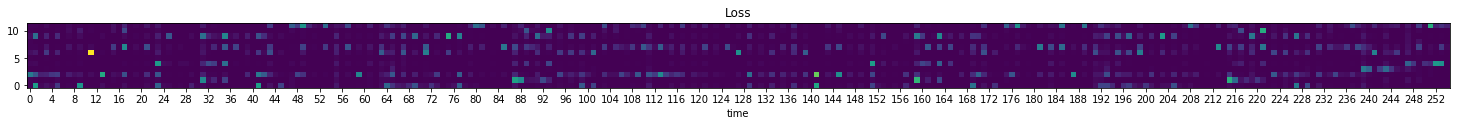

0.158817


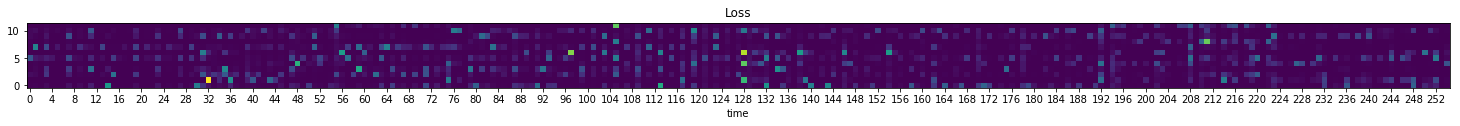

0.158096


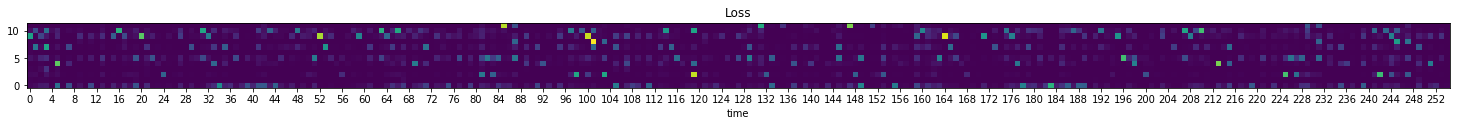

0.164649


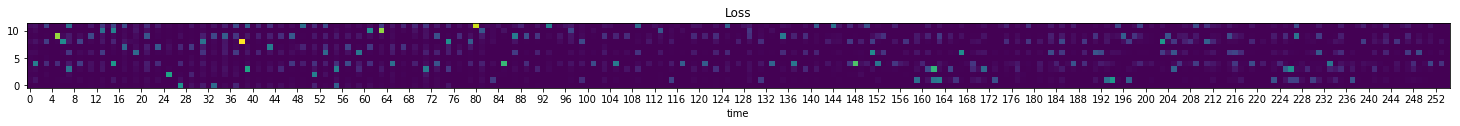

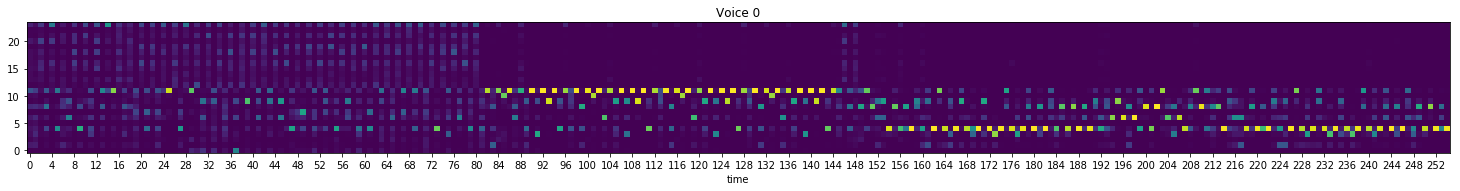

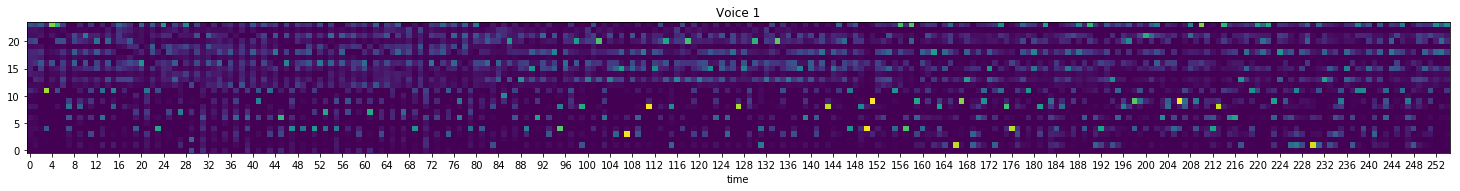

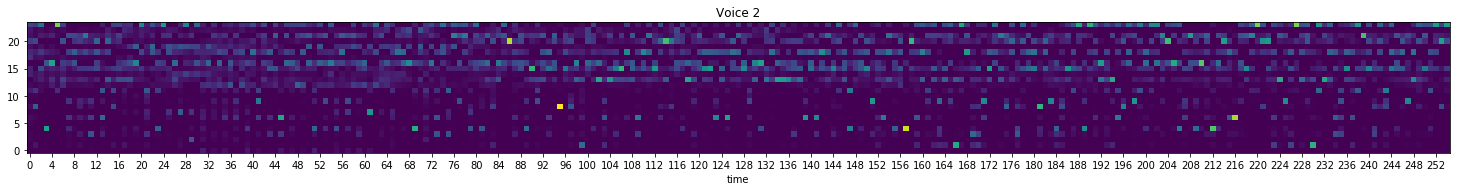

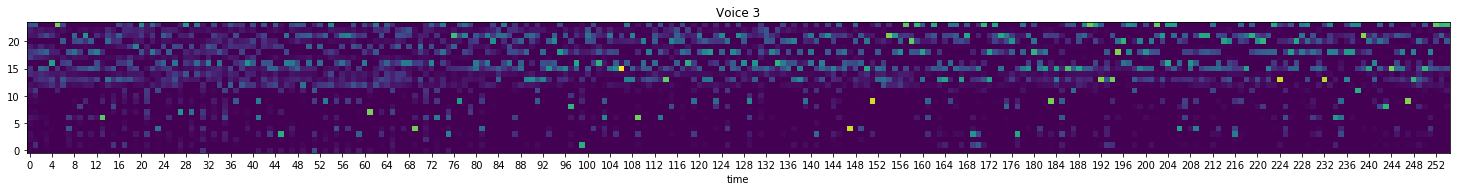

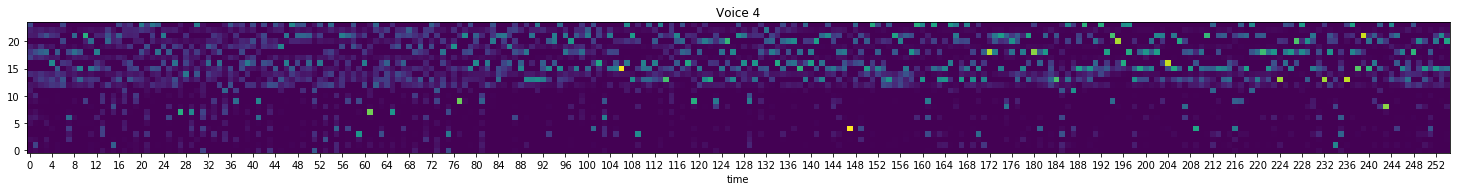

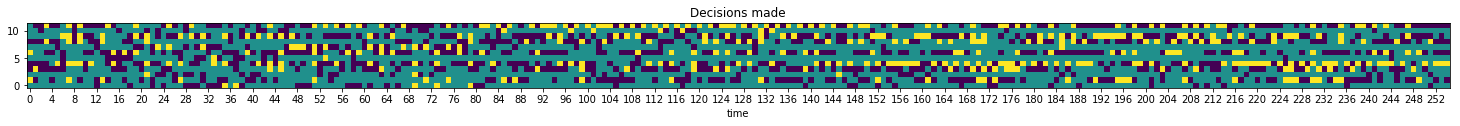

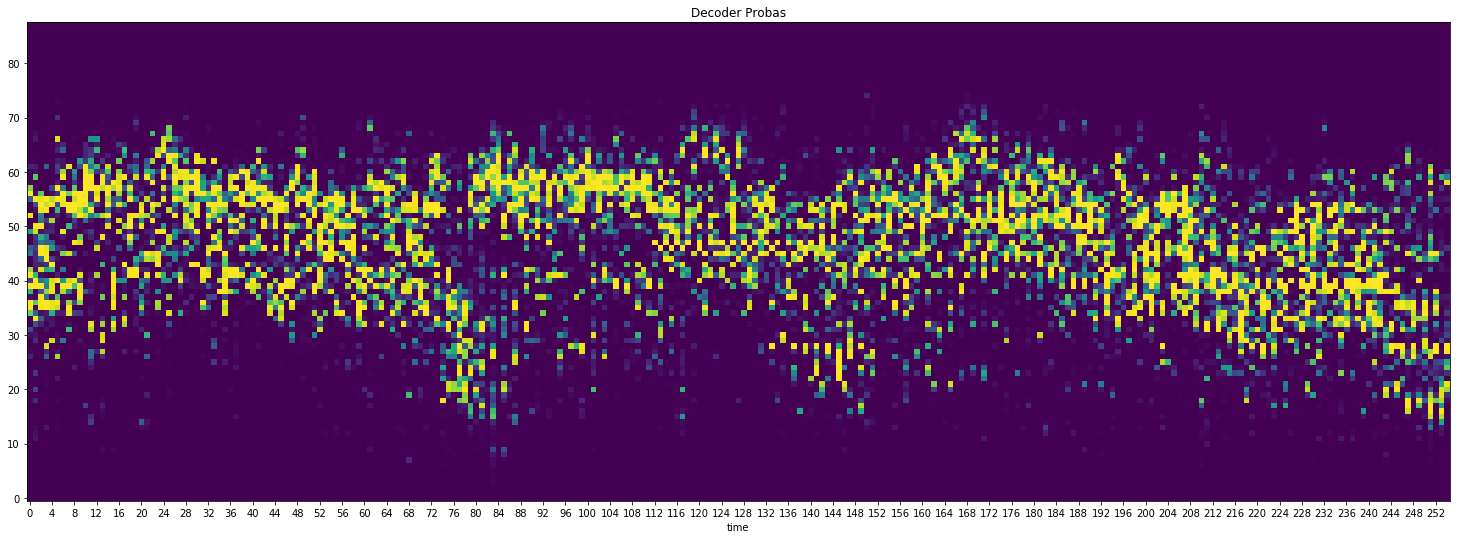

0.161786


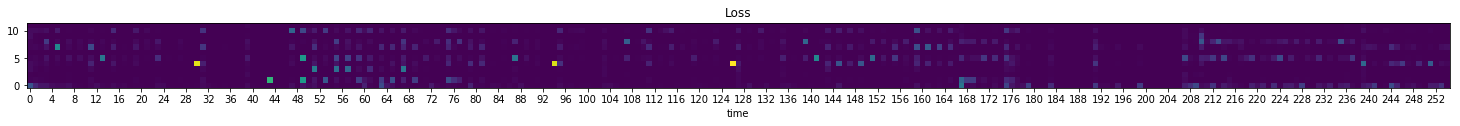

0.163314


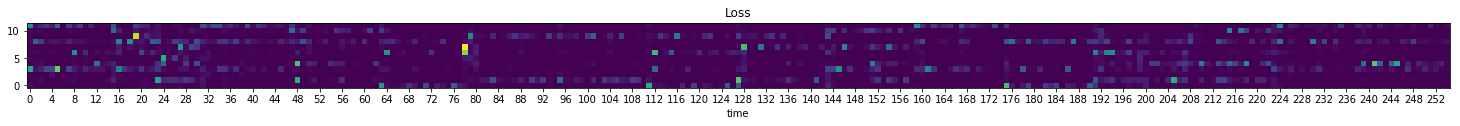

0.153549


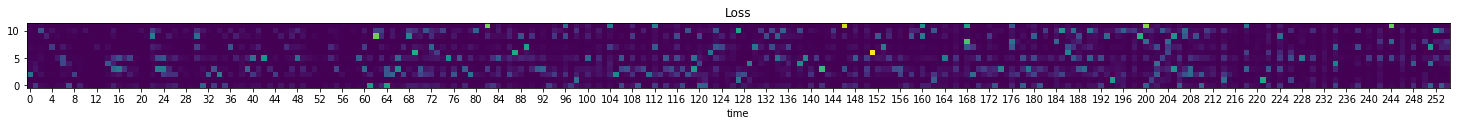

0.161081


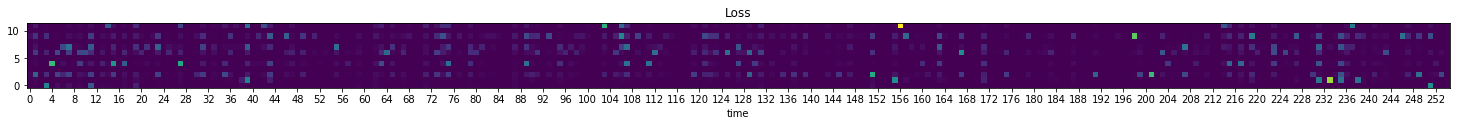

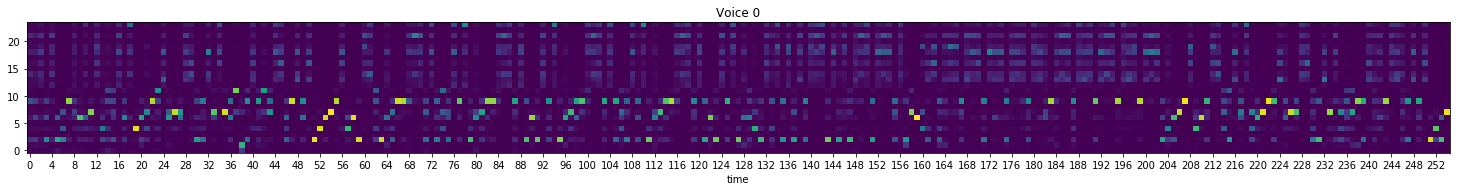

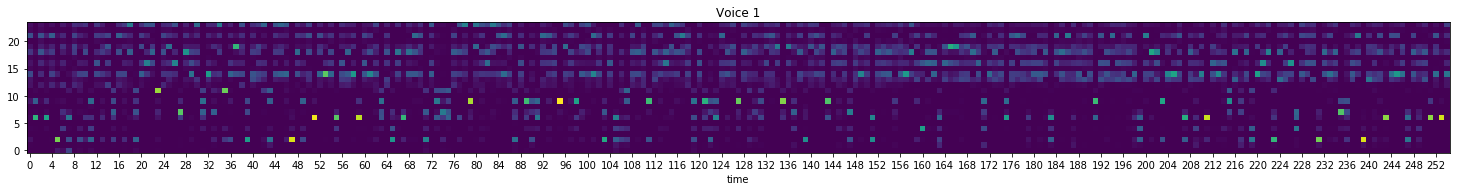

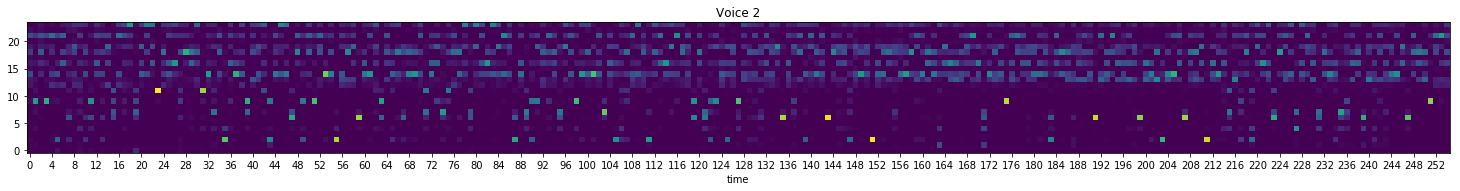

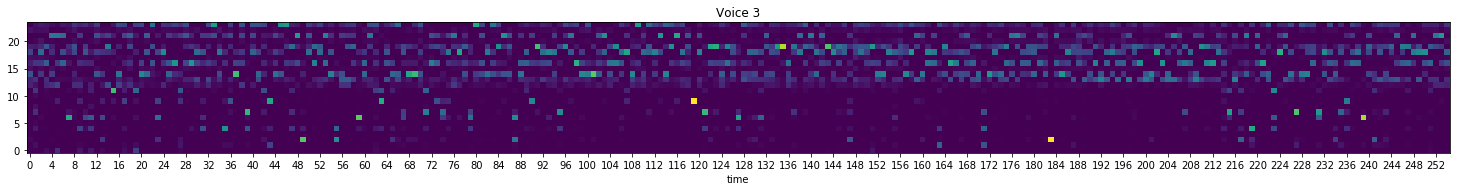

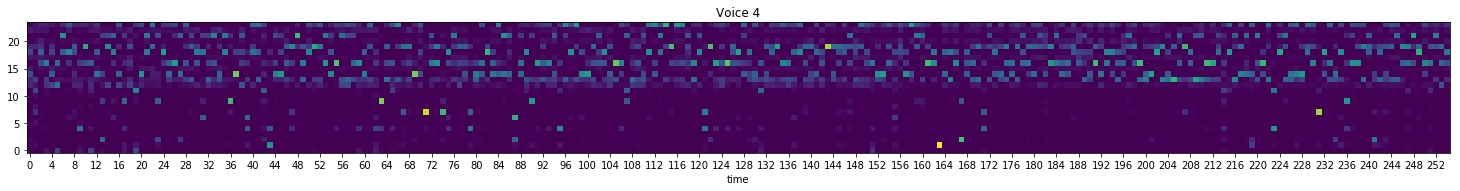

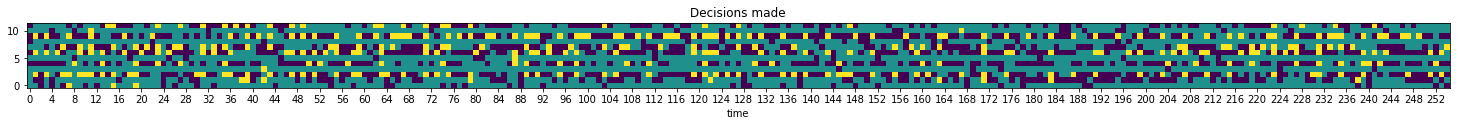

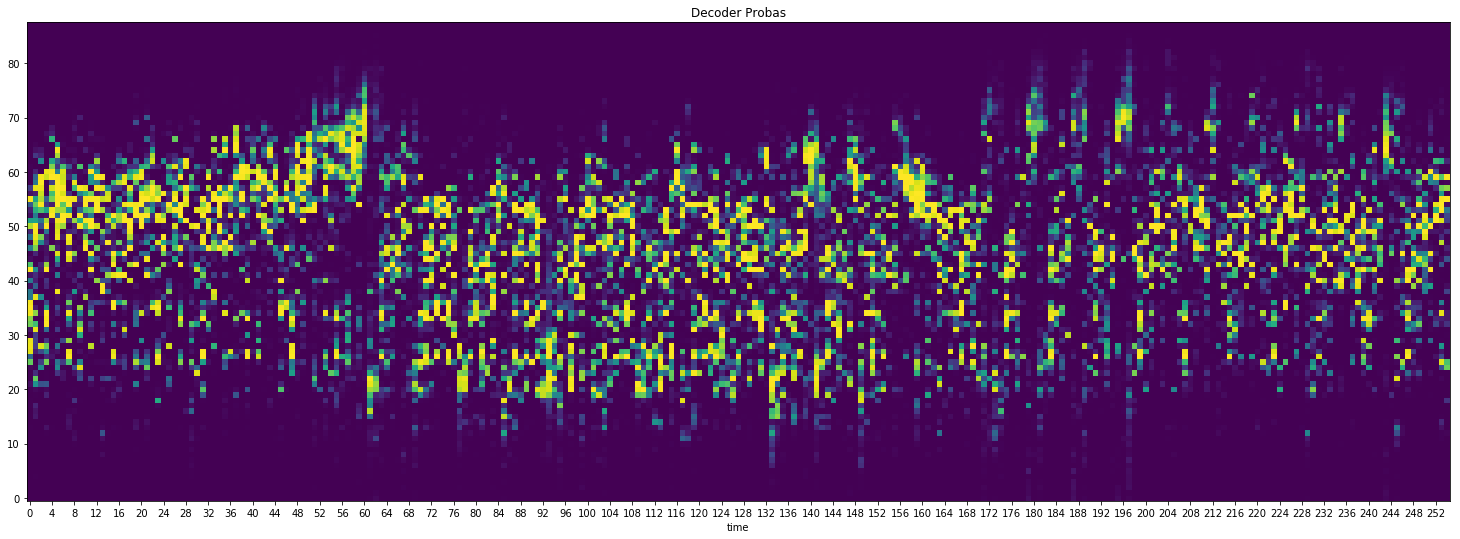

0.156311


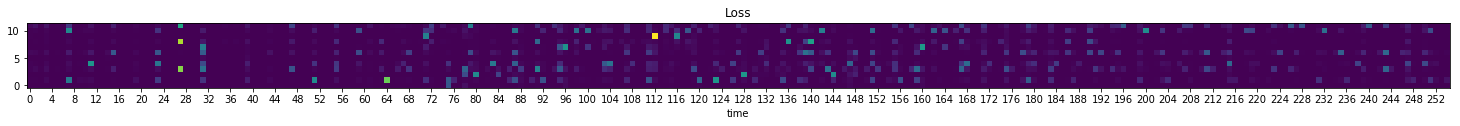

0.164735


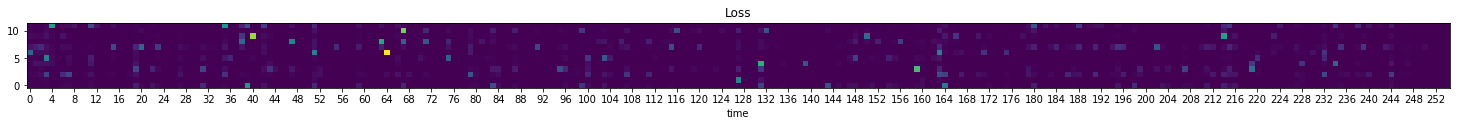

0.167706


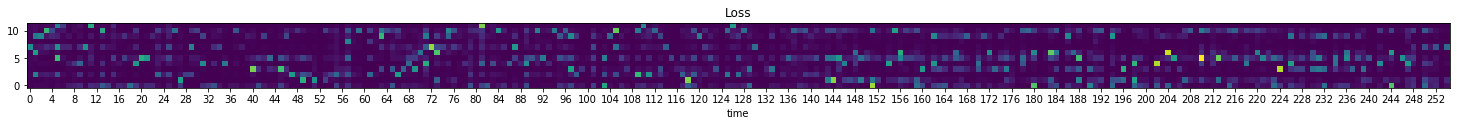

0.164672


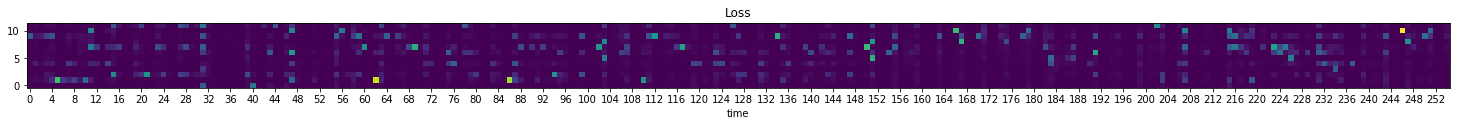

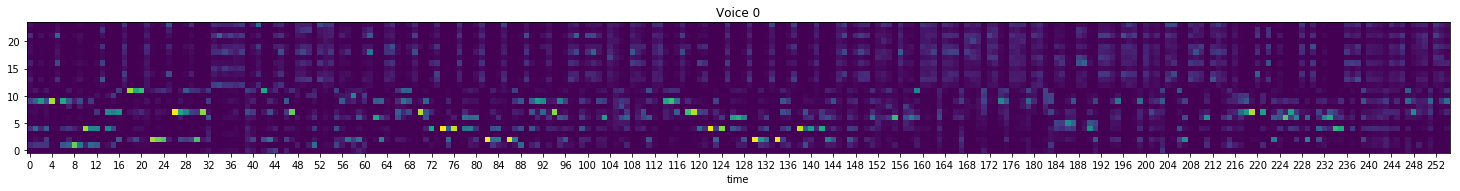

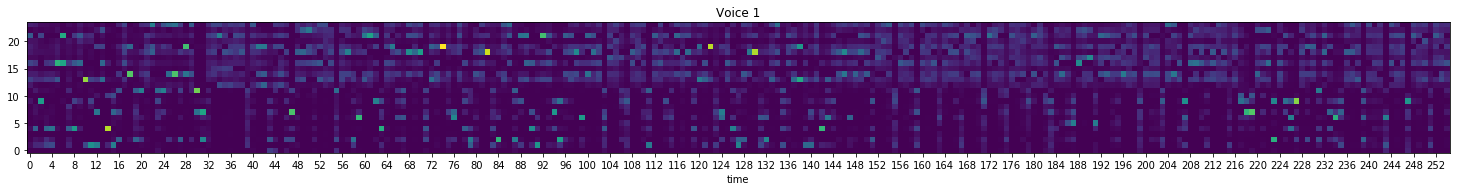

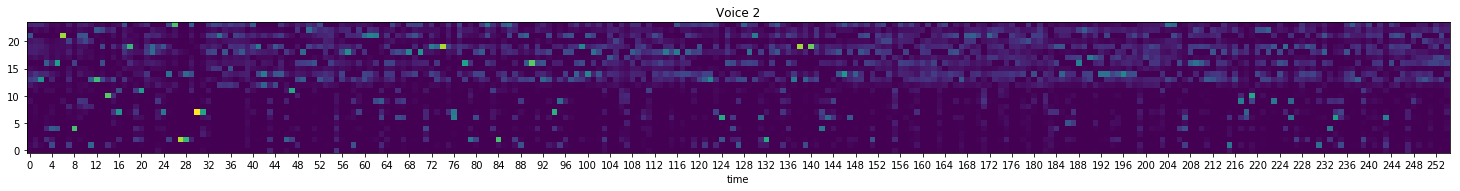

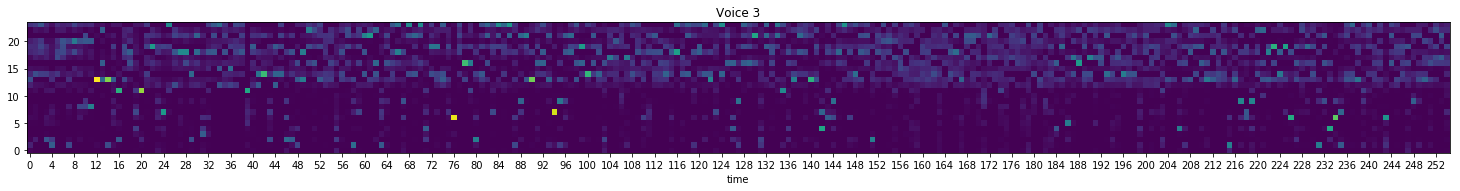

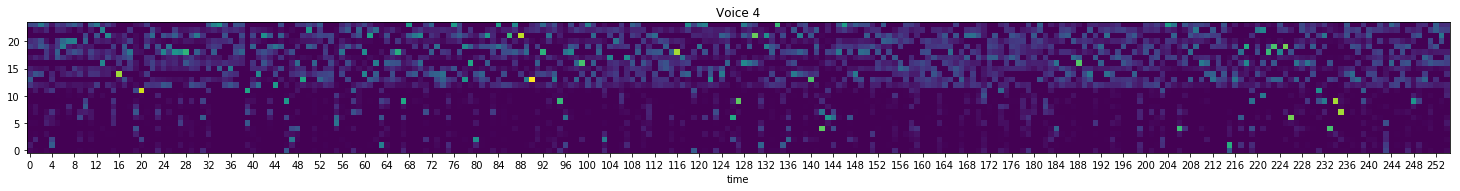

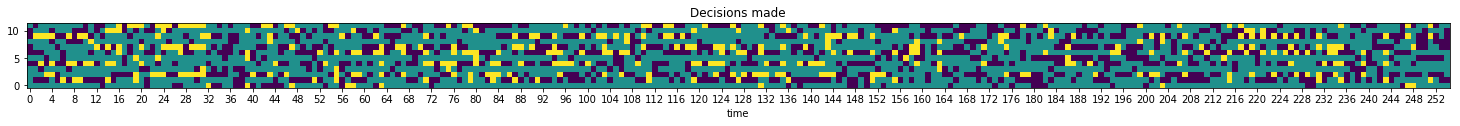

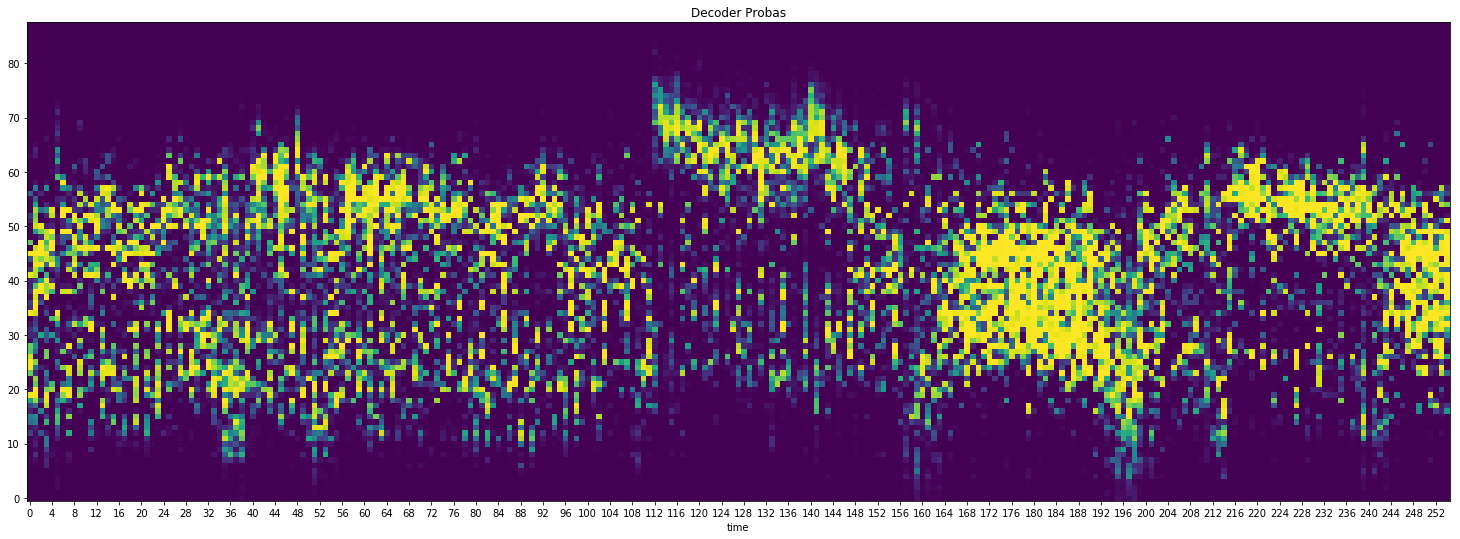

0.154902


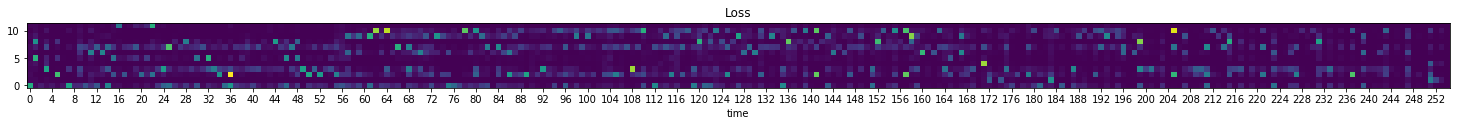

0.150183


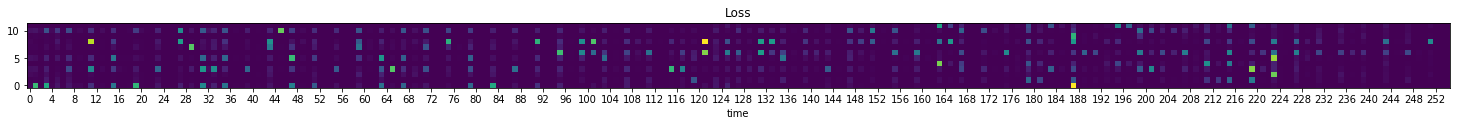

0.152805


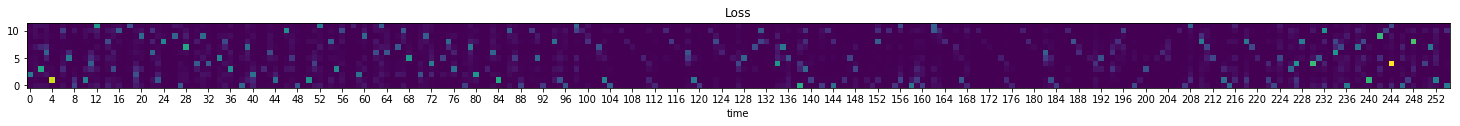

0.161332


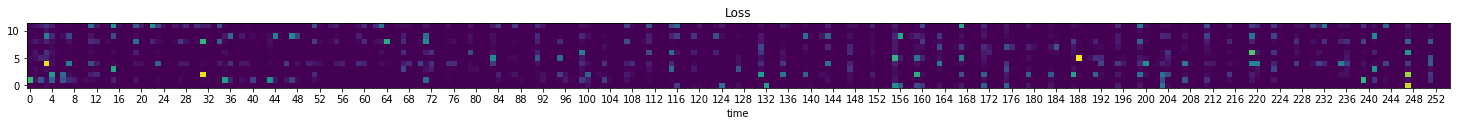

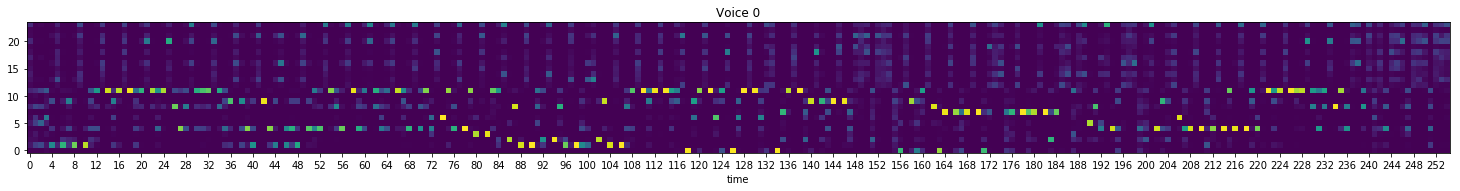

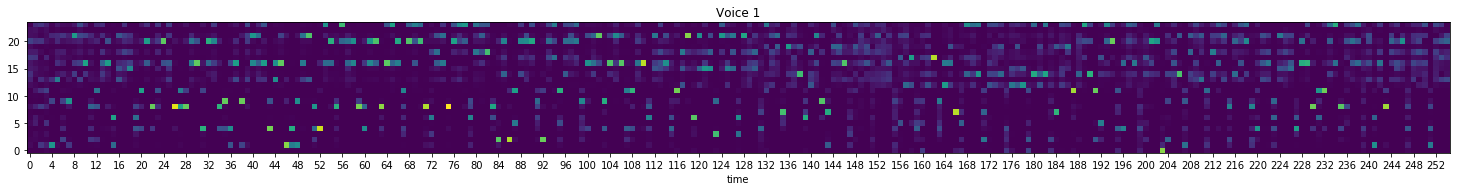

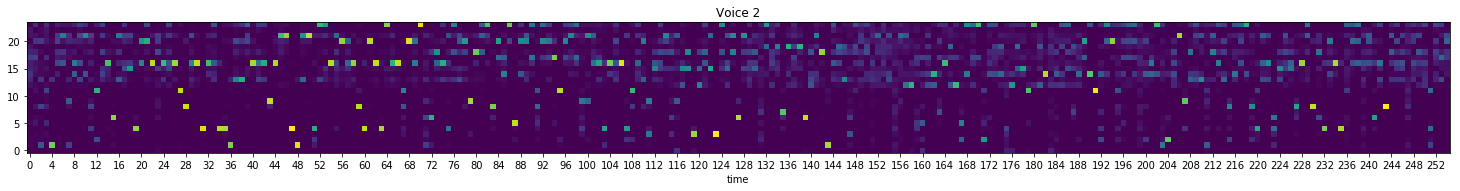

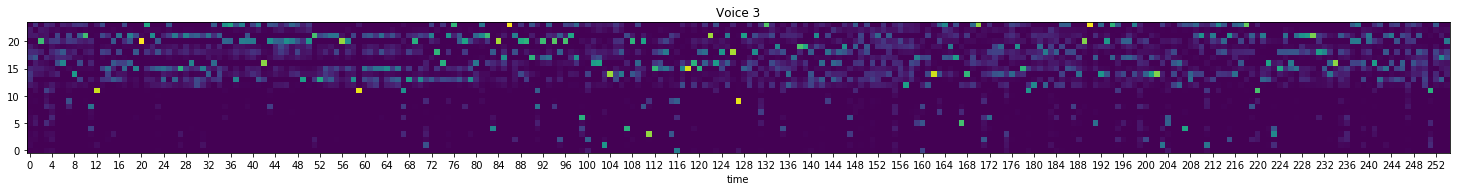

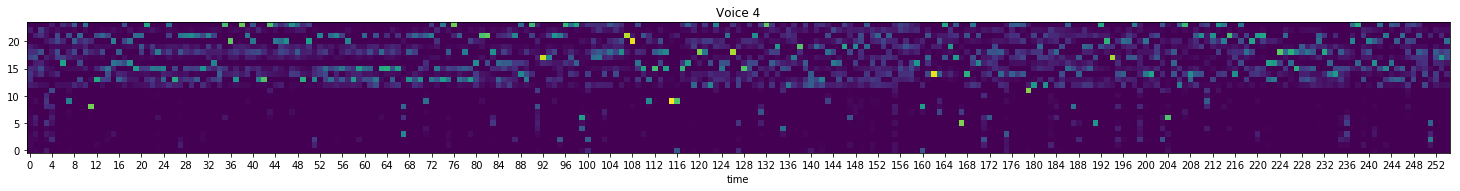

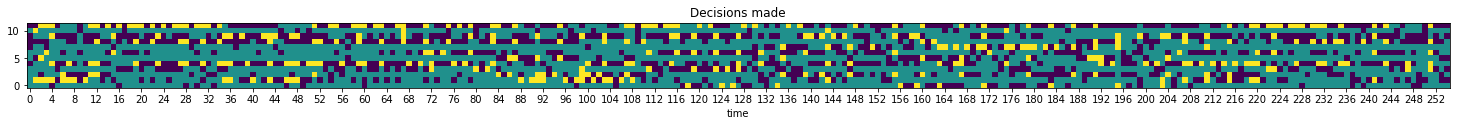

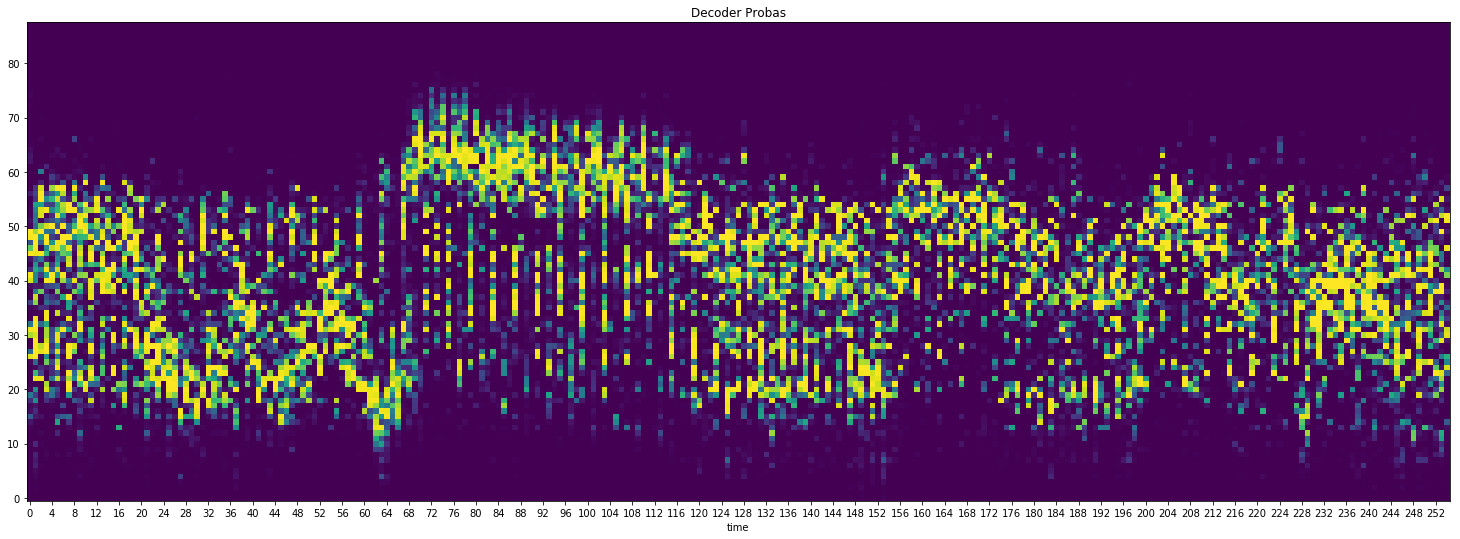

0.161184


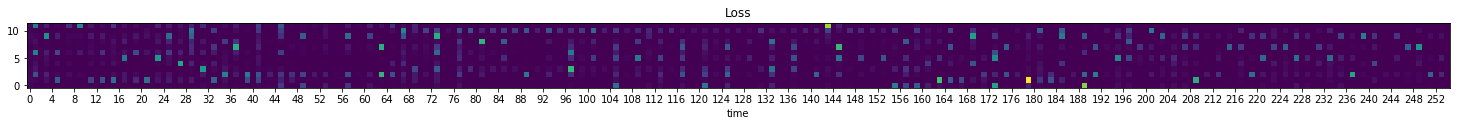

0.163473


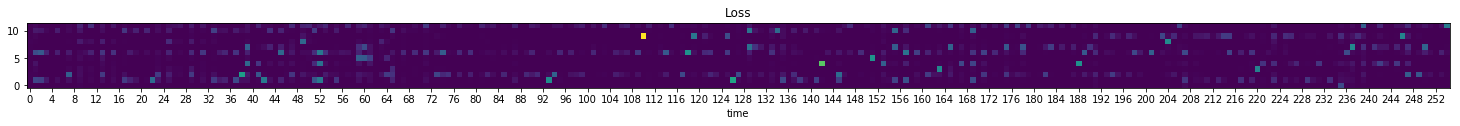

0.158246


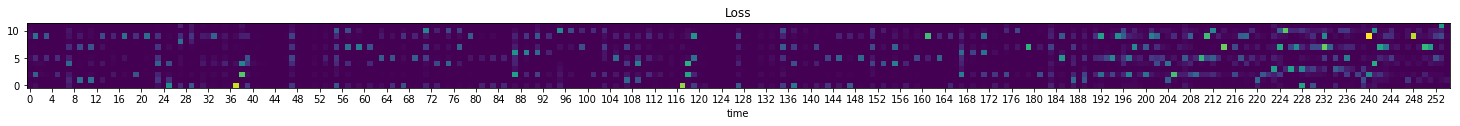

0.153686


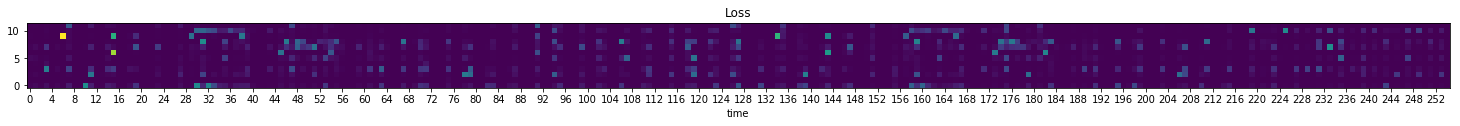

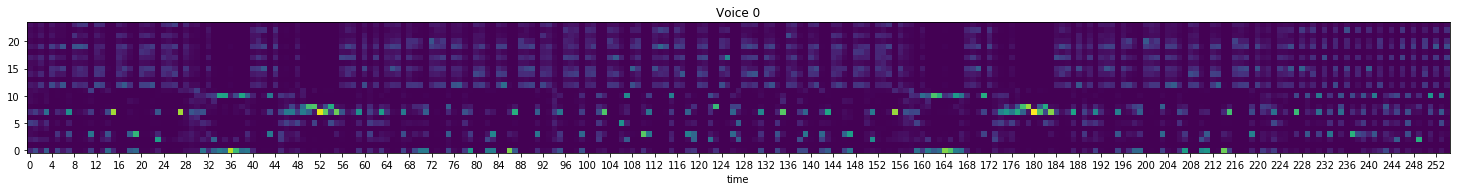

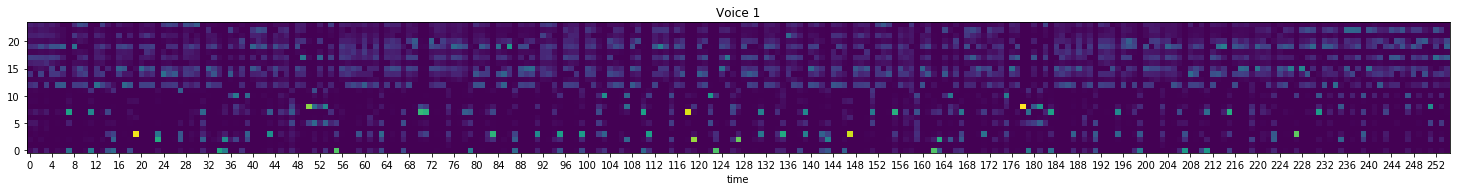

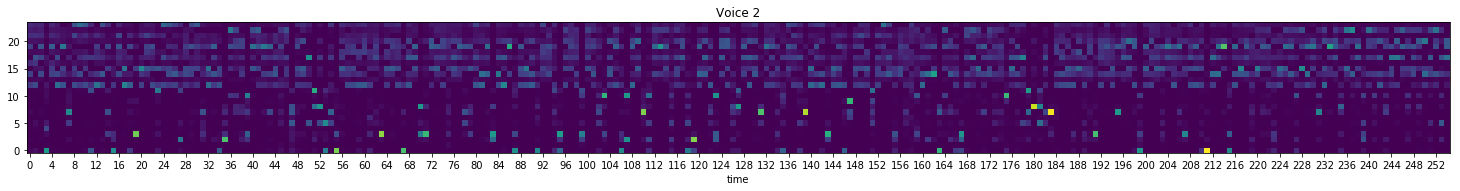

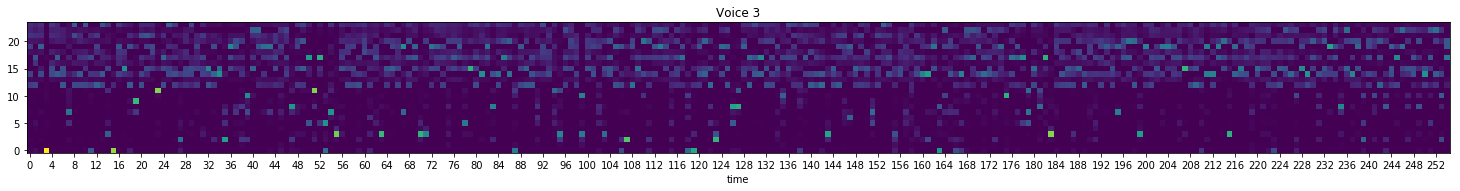

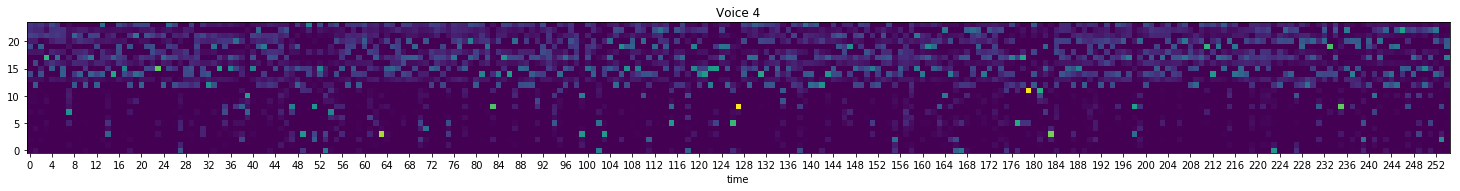

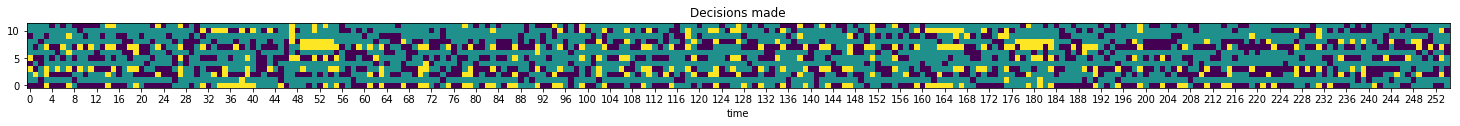

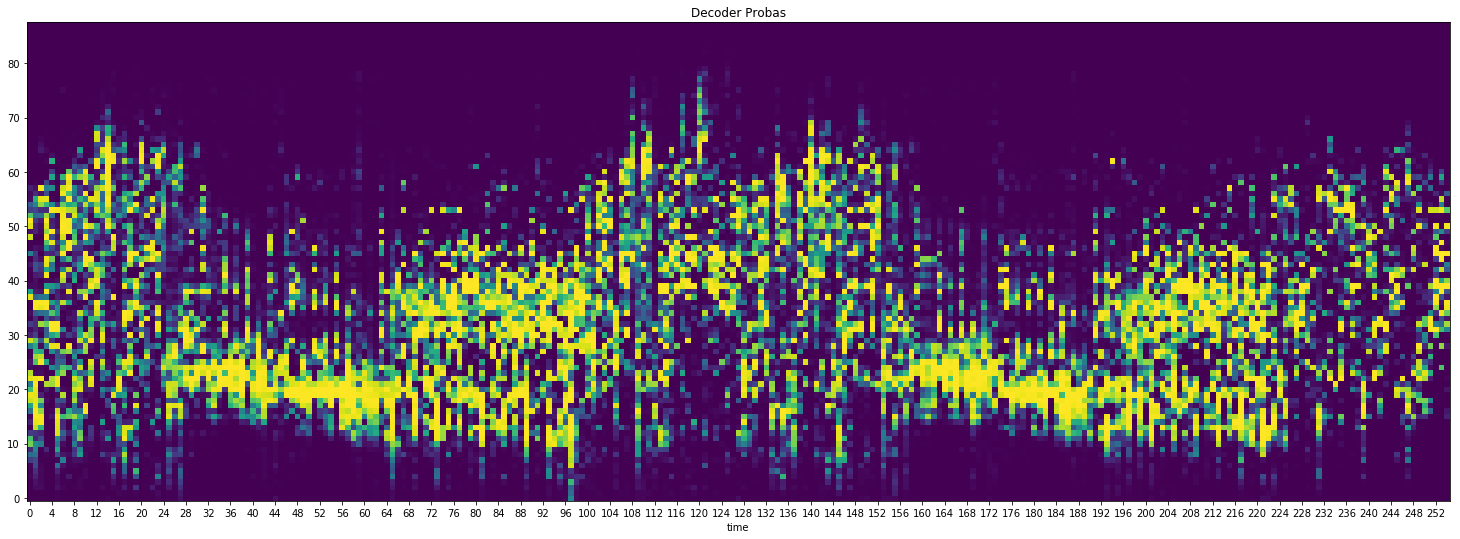

0.151535


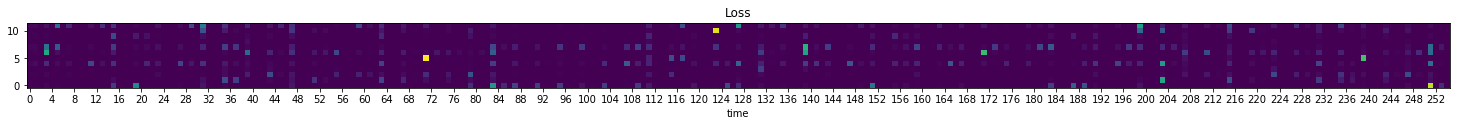

0.155914


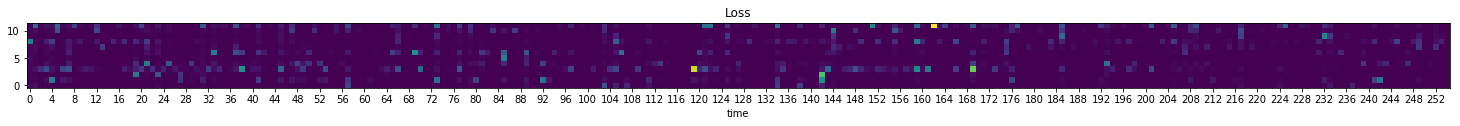

0.160585


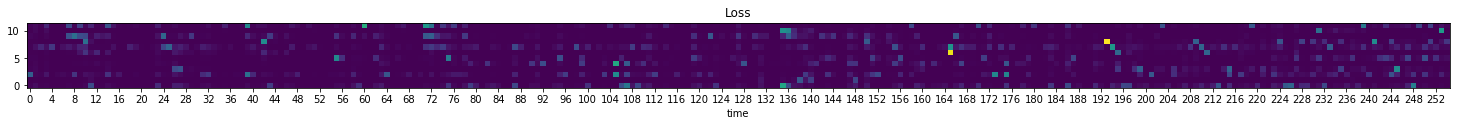

0.163796


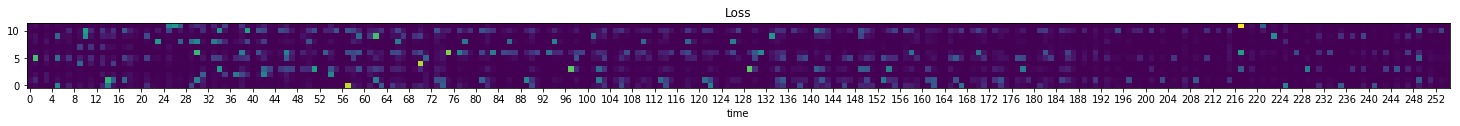

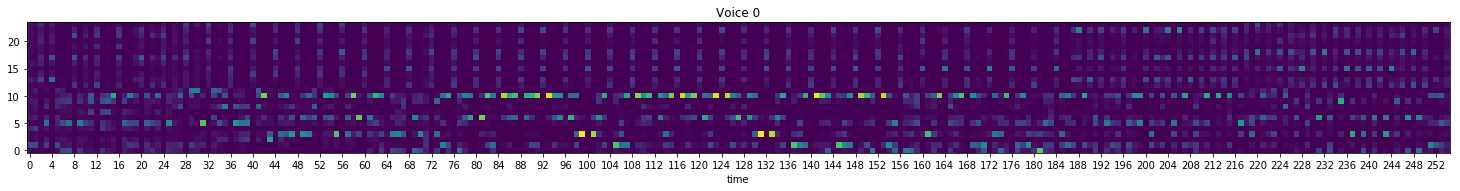

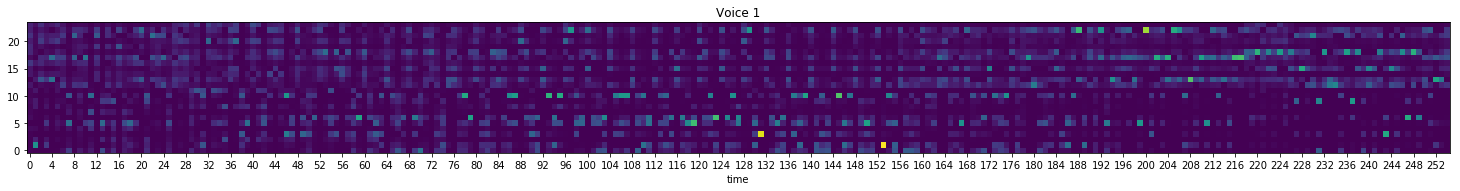

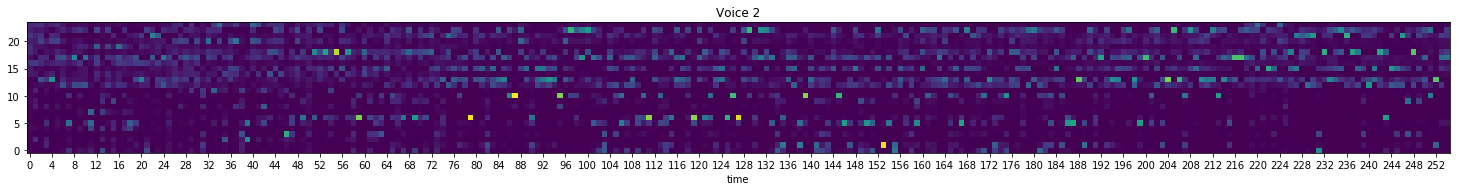

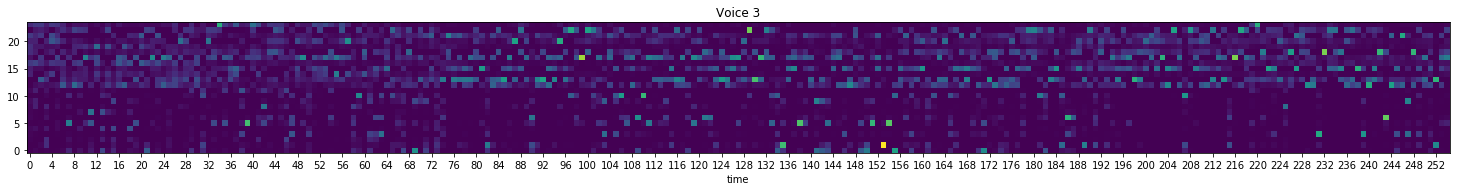

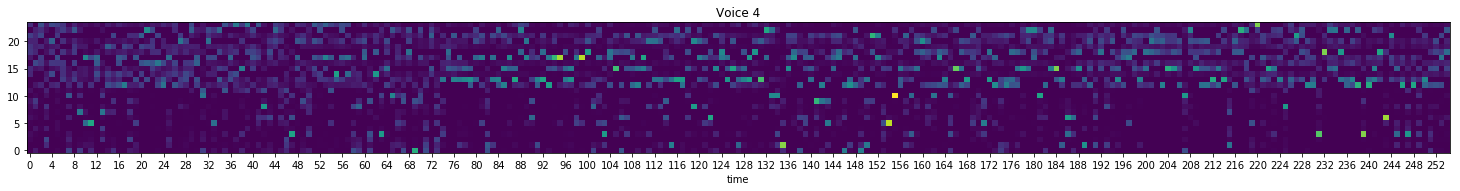

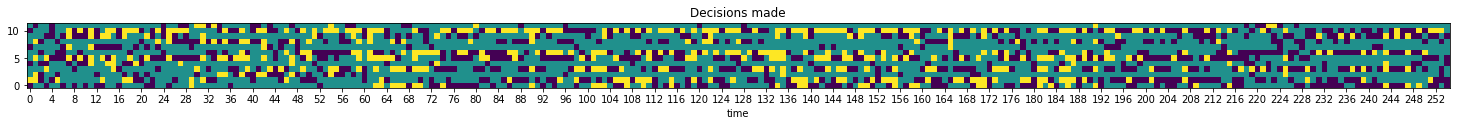

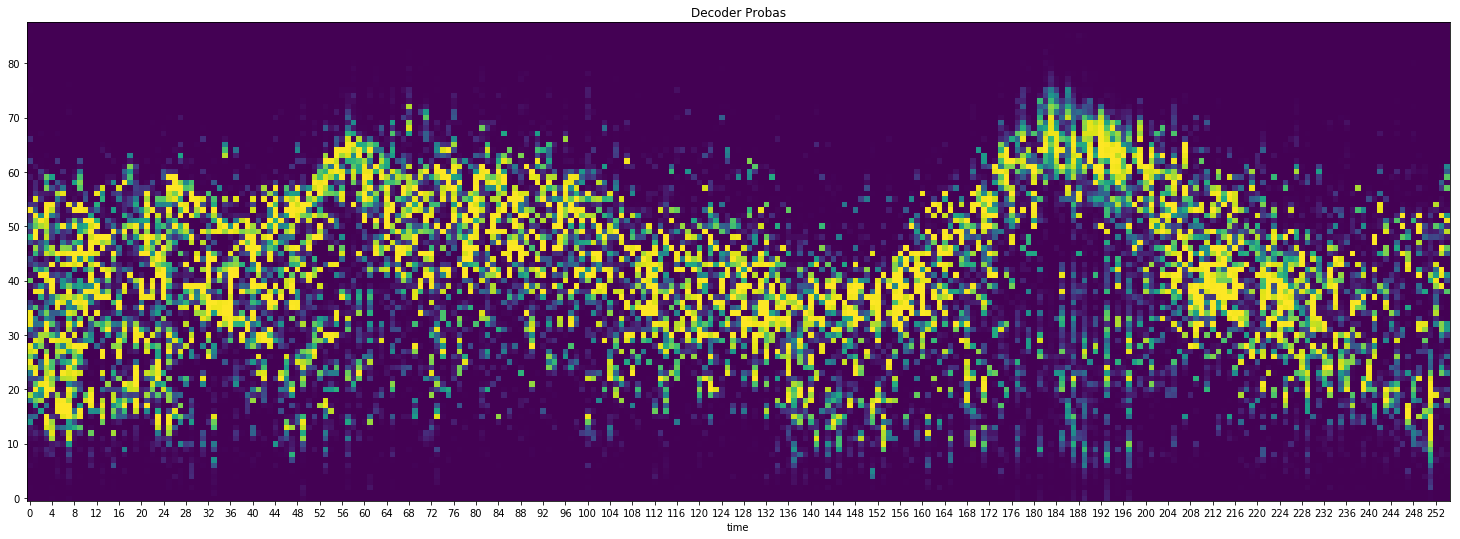

0.160724


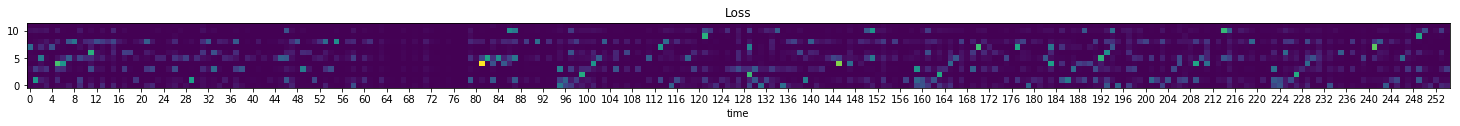

0.159771


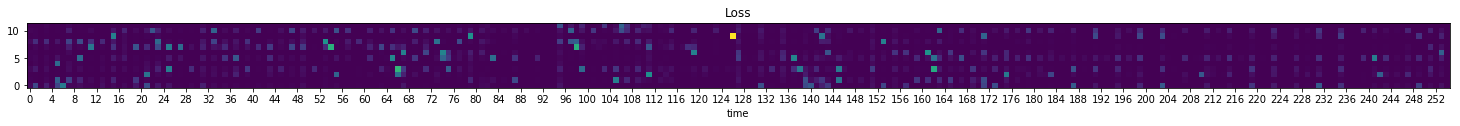

0.156188


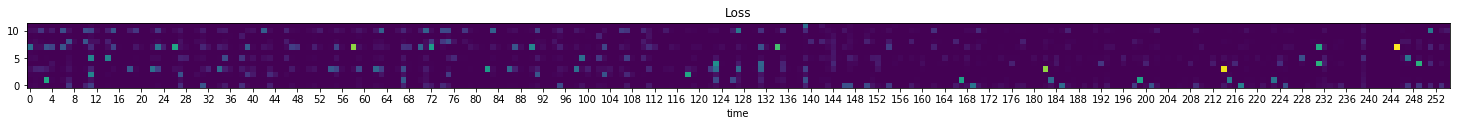

0.16883


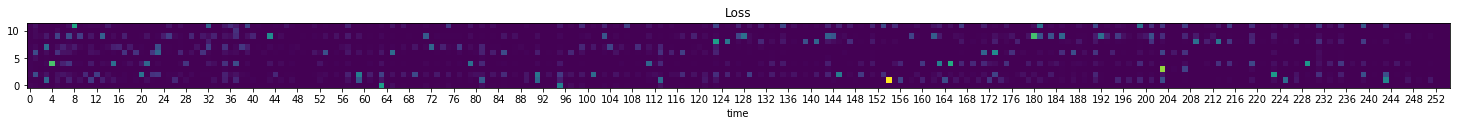

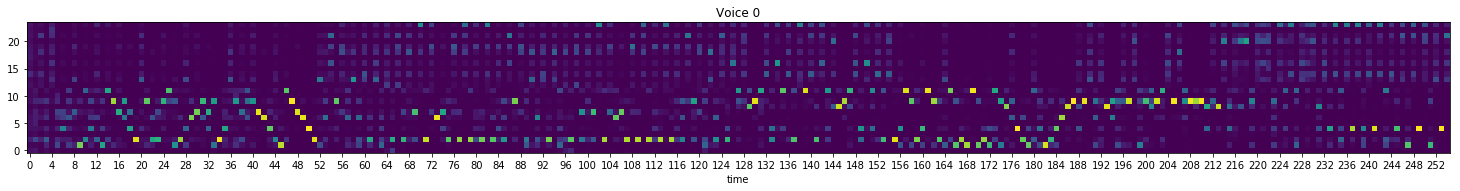

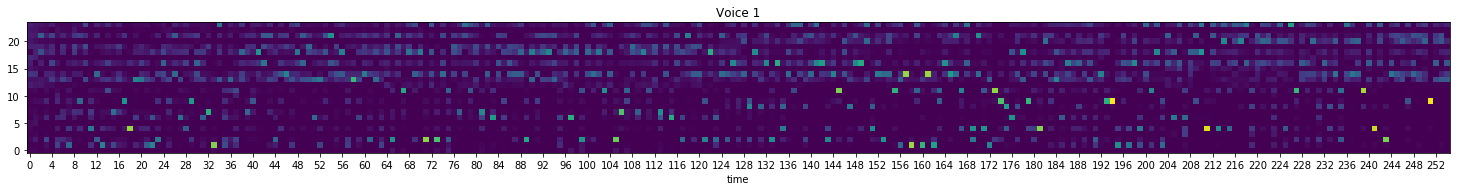

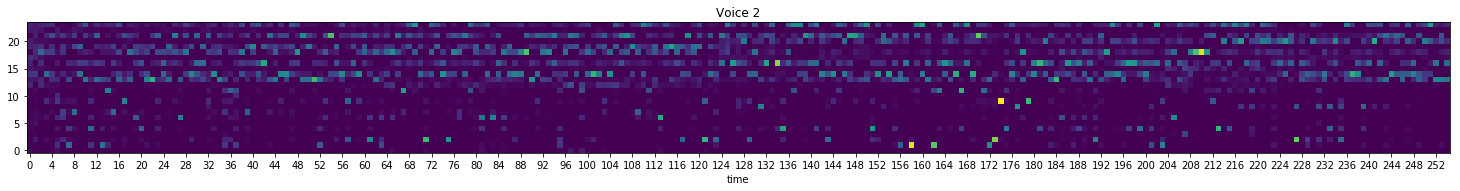

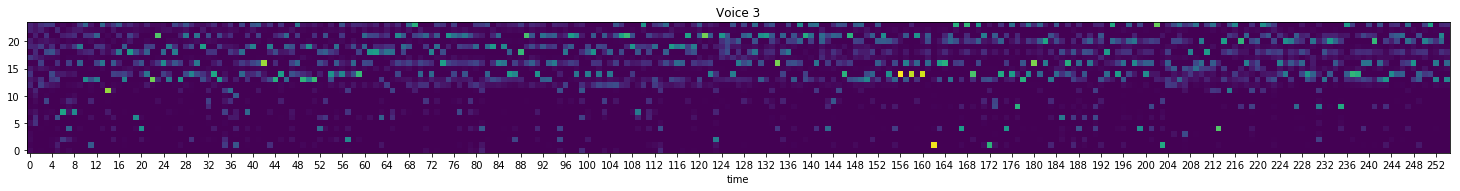

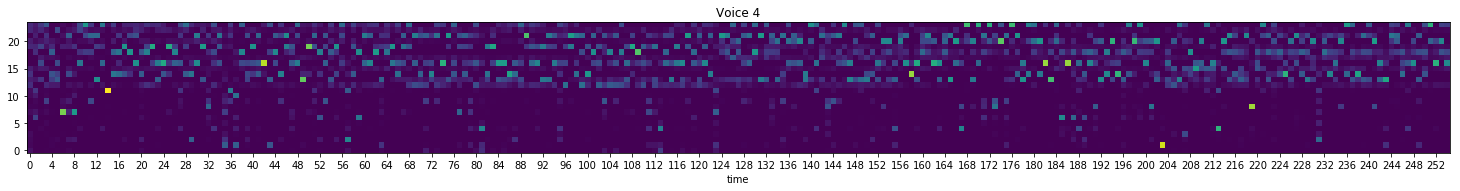

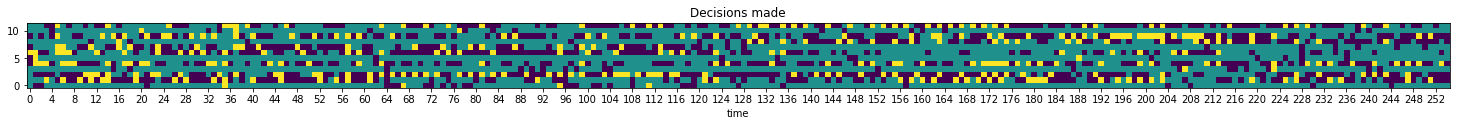

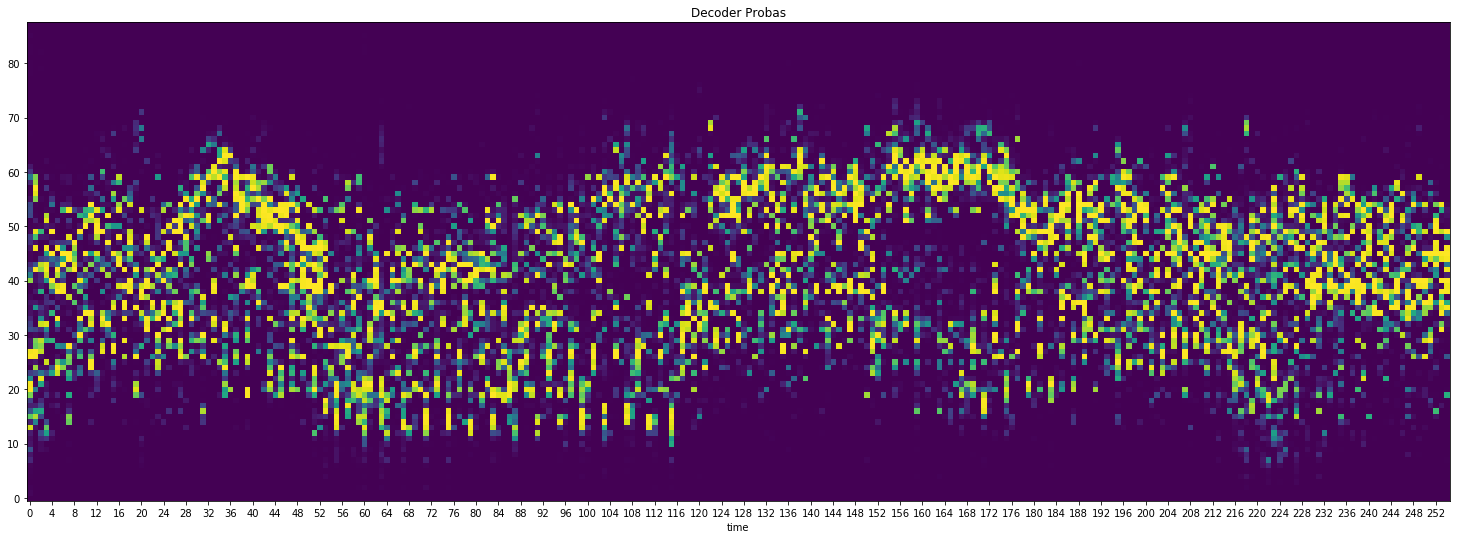

0.161681


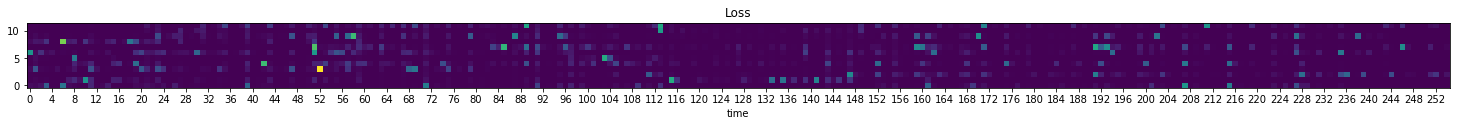

0.158349


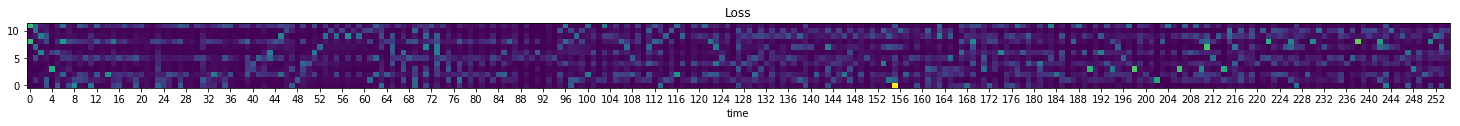

0.151527


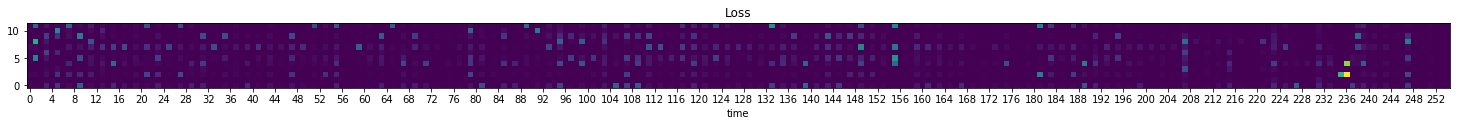

0.148862


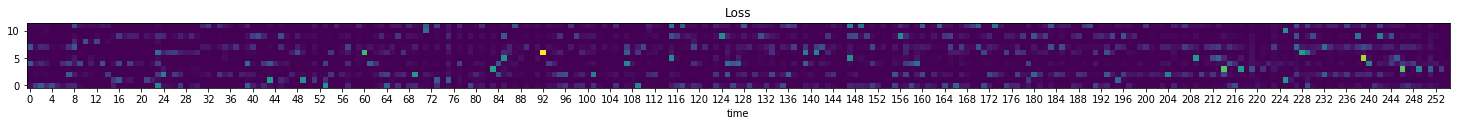

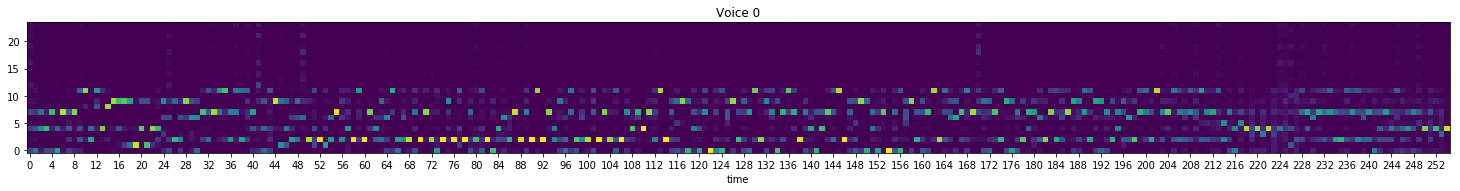

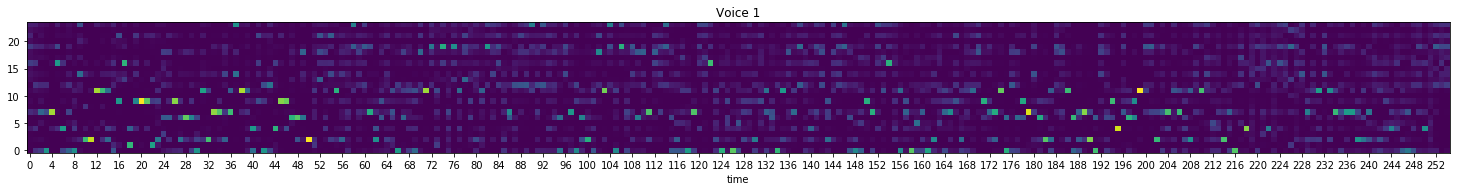

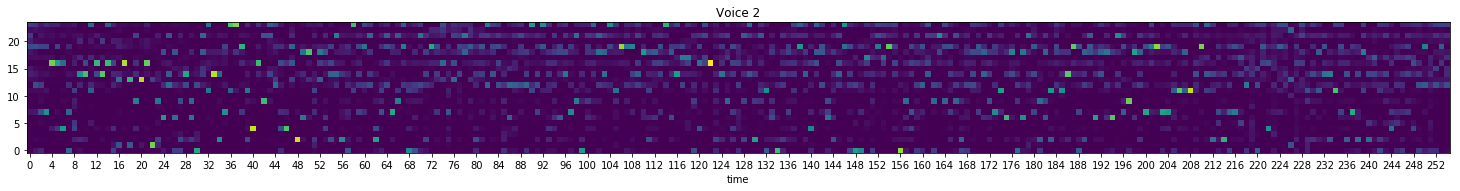

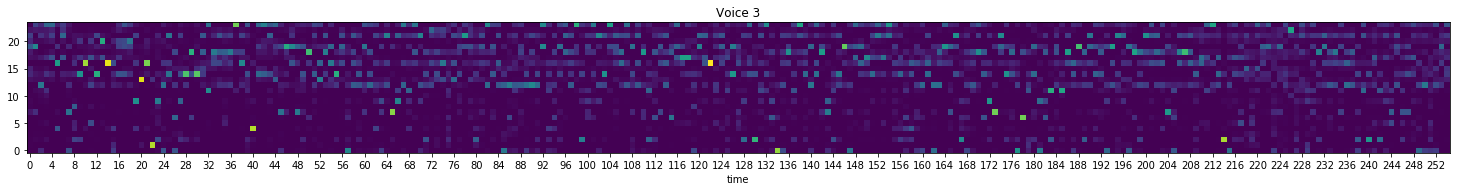

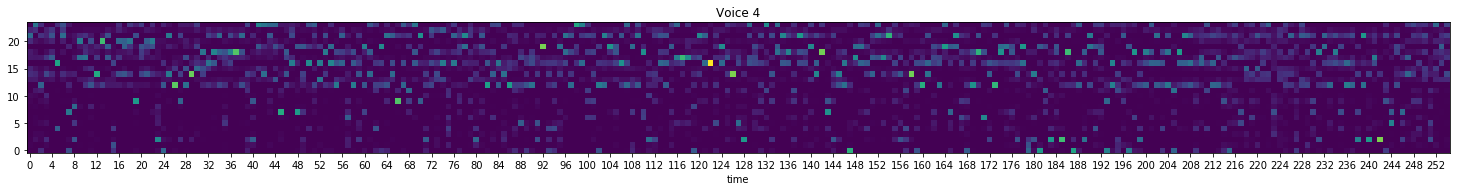

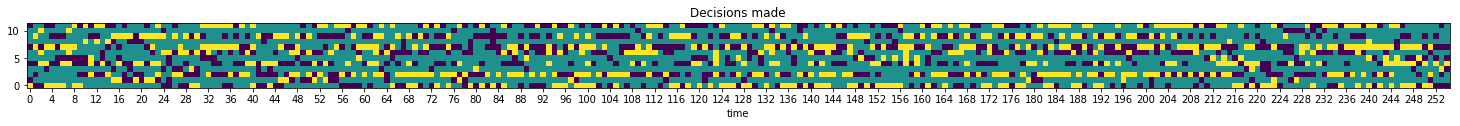

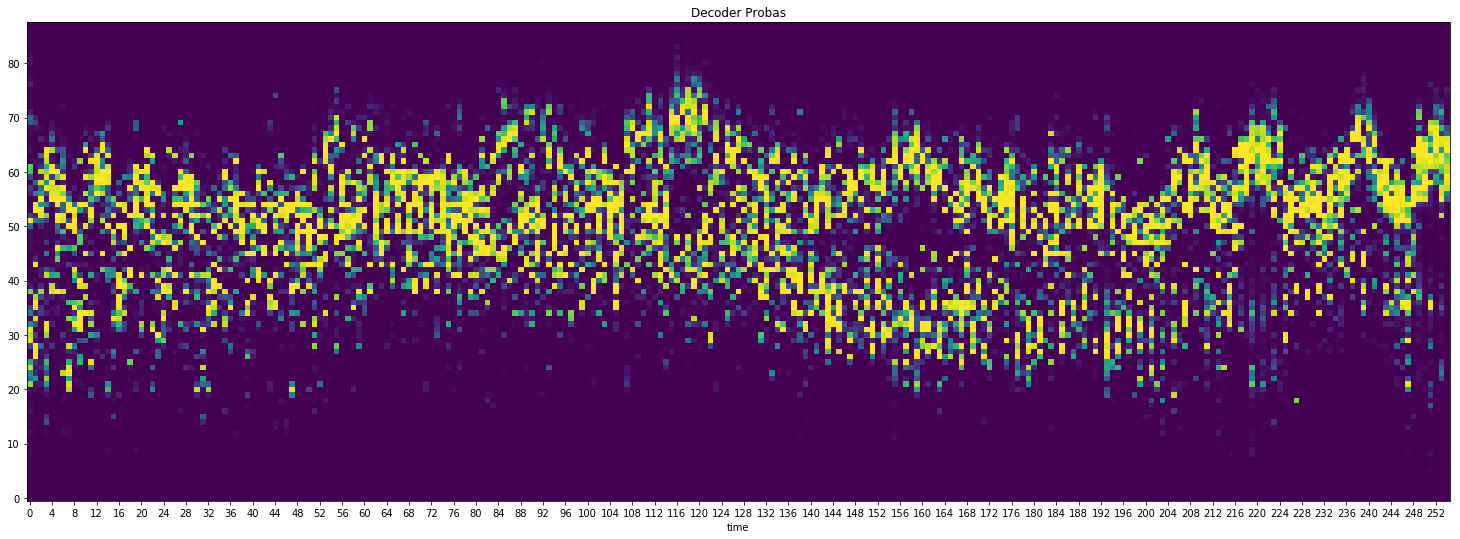

0.149753


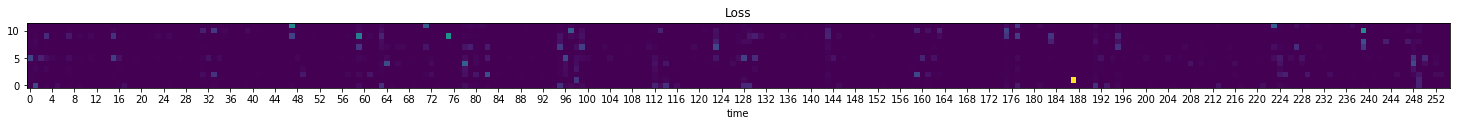

0.162832


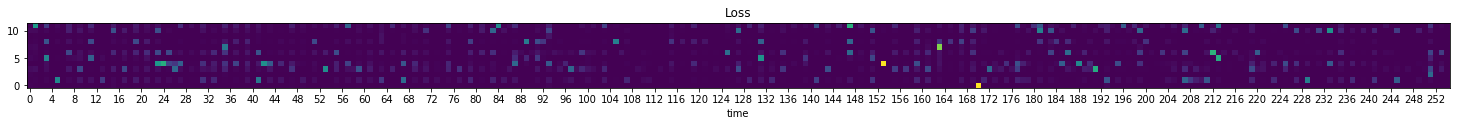

0.16651


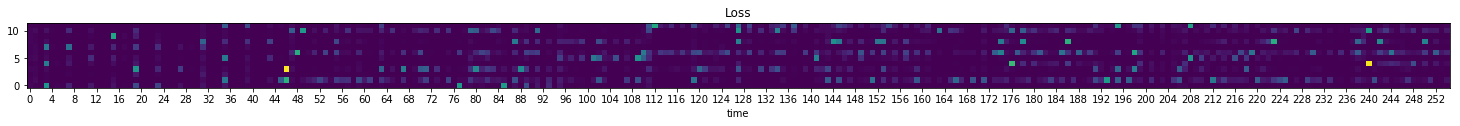

0.166463


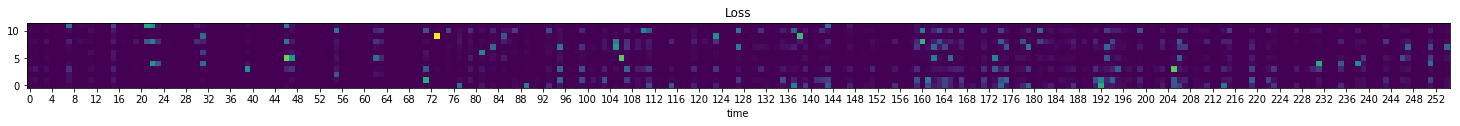

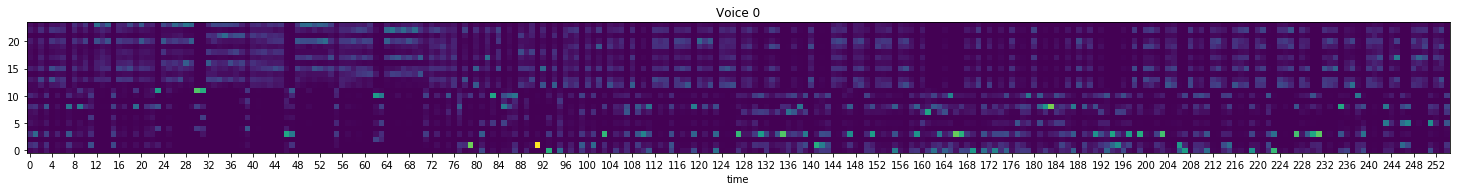

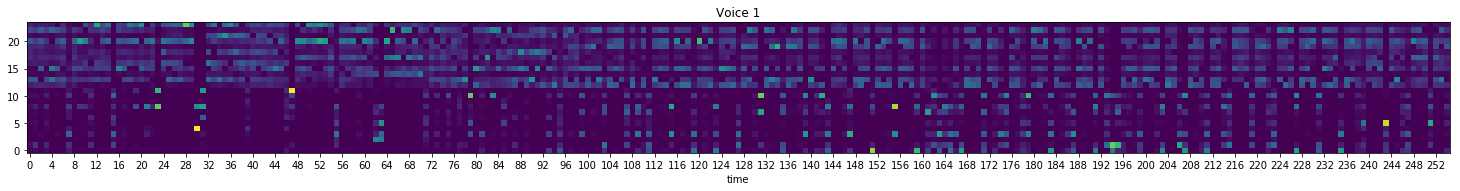

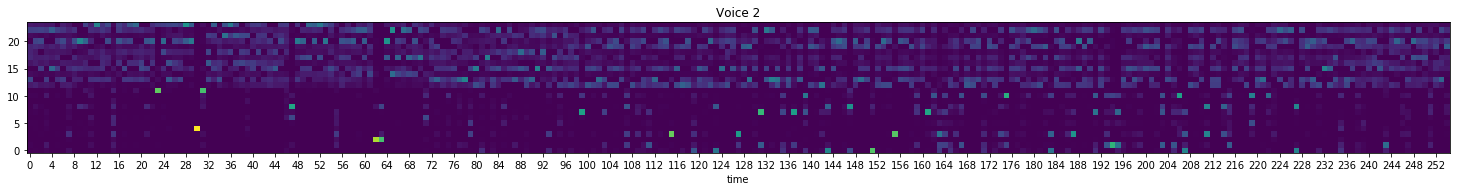

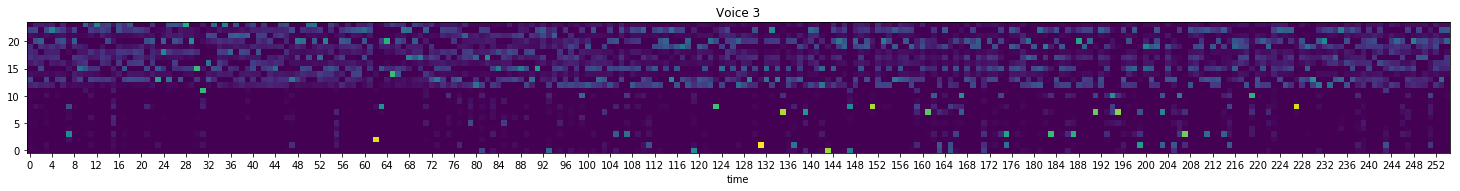

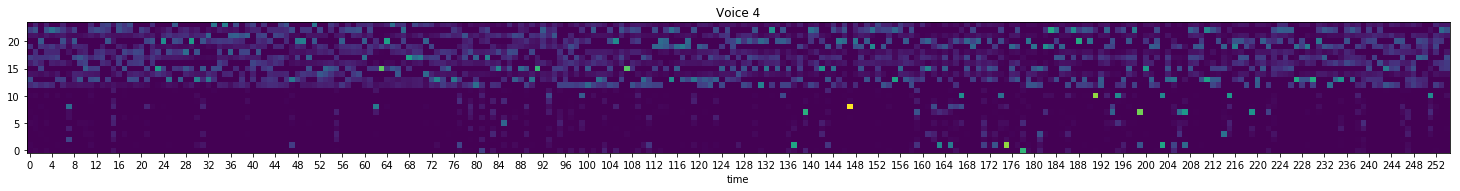

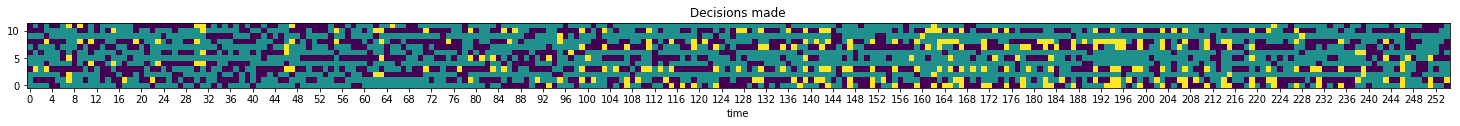

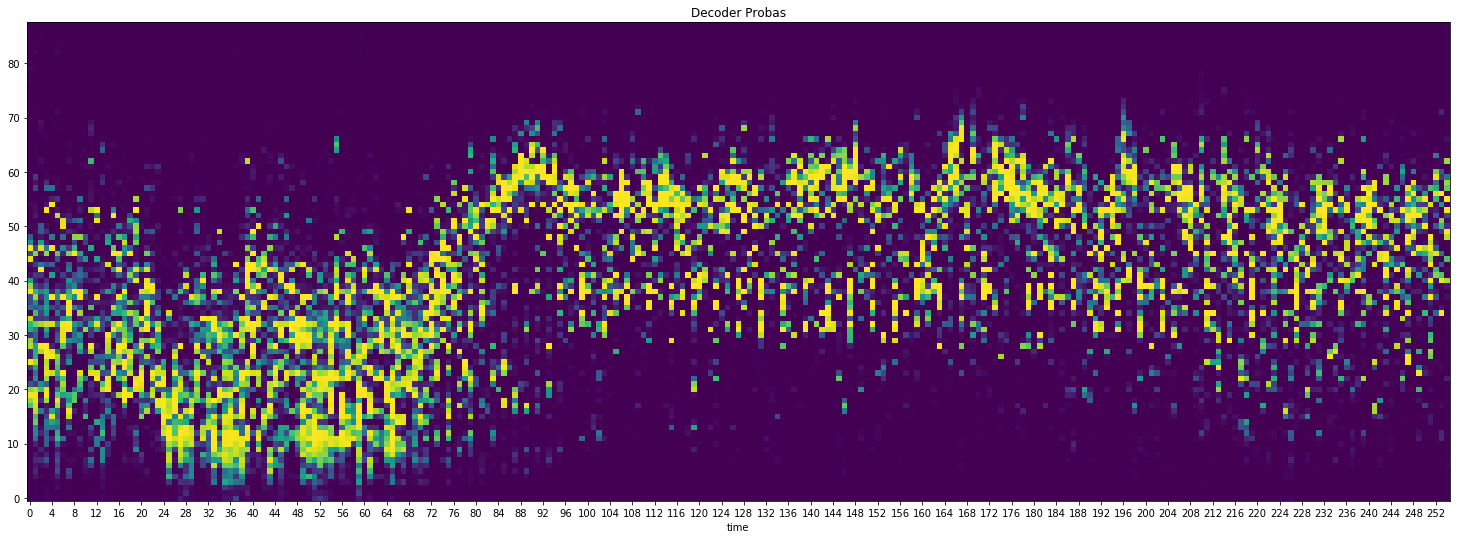

0.151495


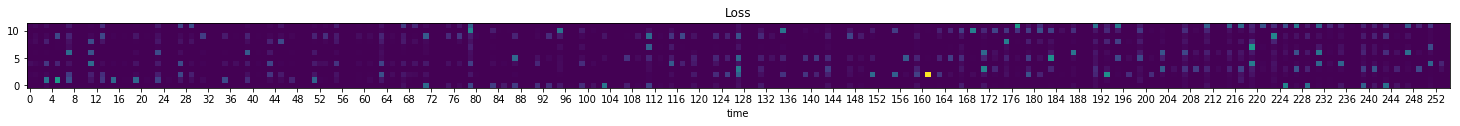

0.155179


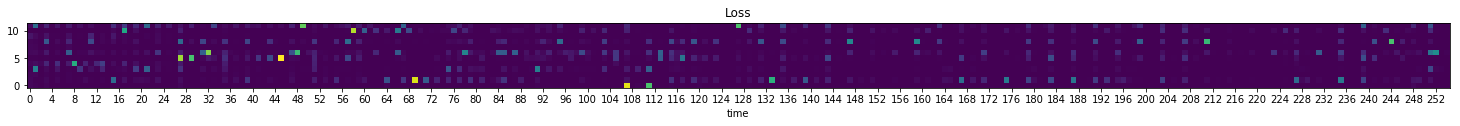

0.151748


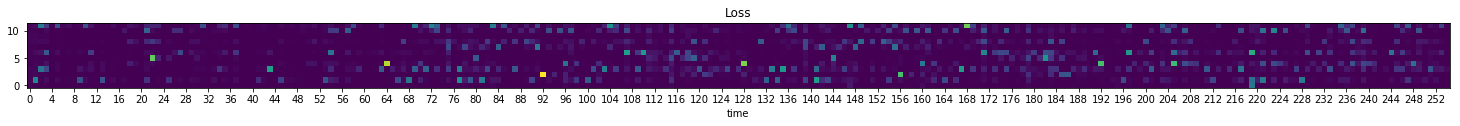

0.149837


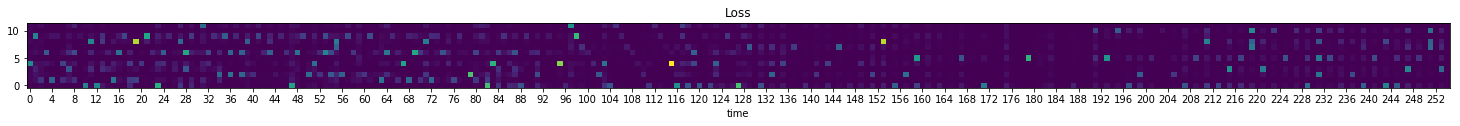

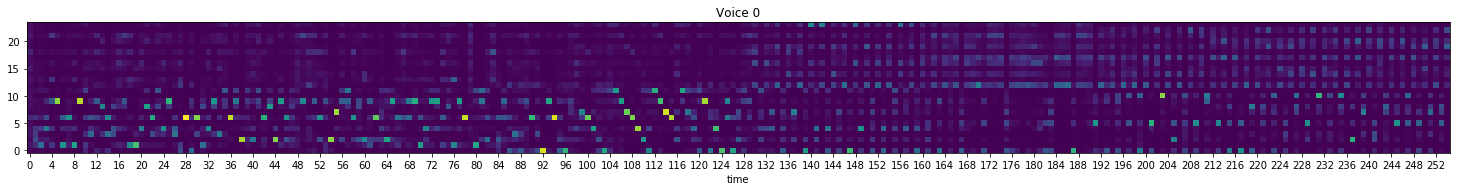

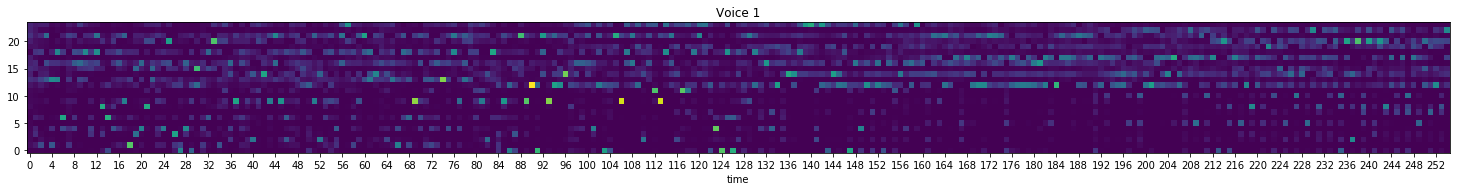

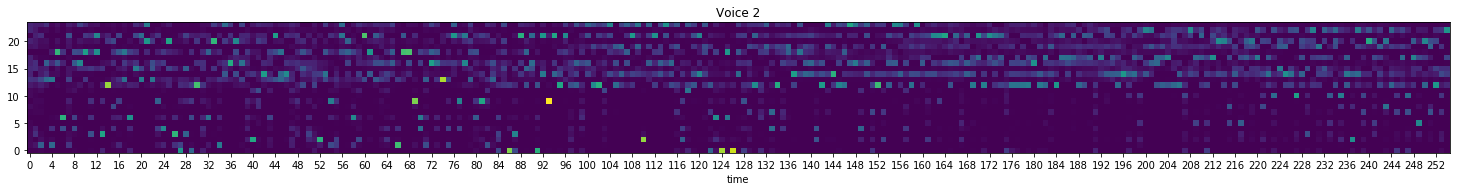

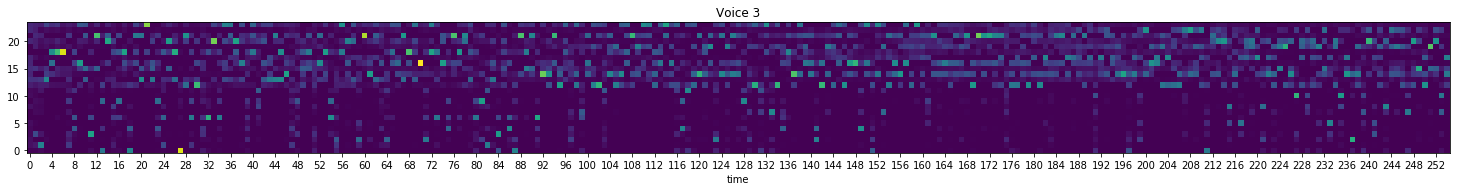

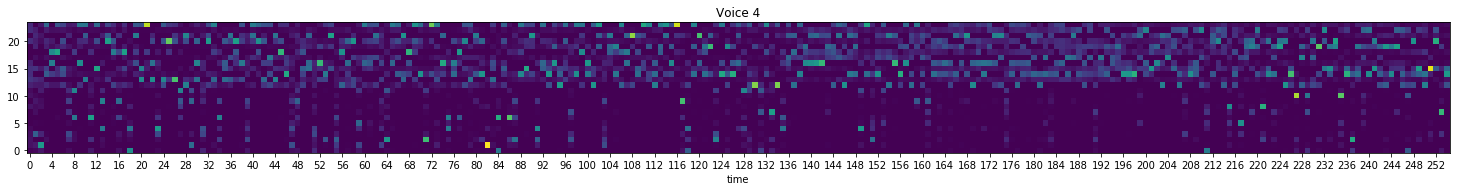

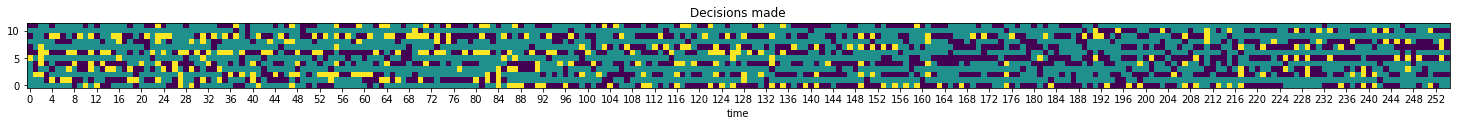

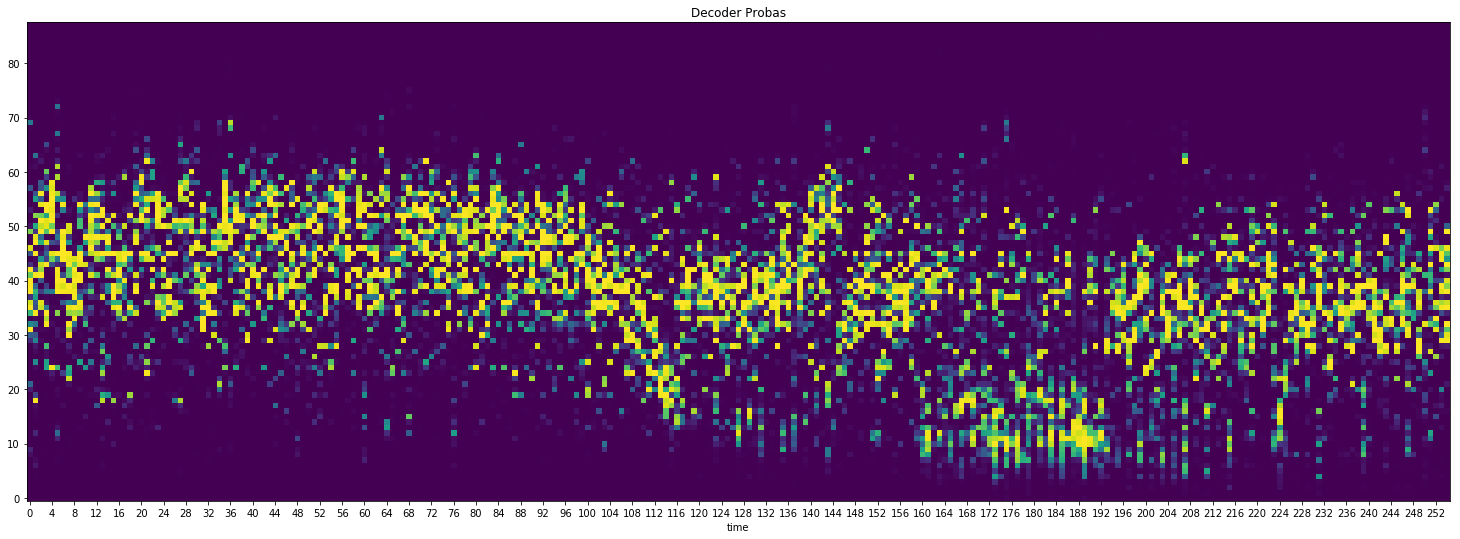

0.157329


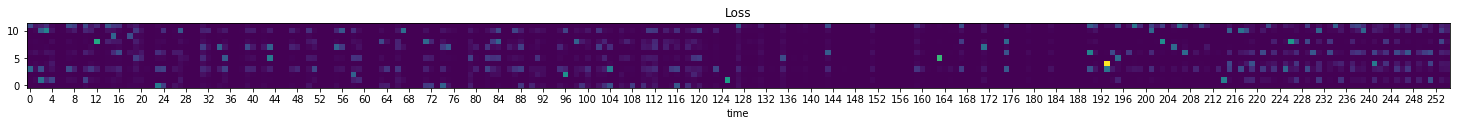

0.148398


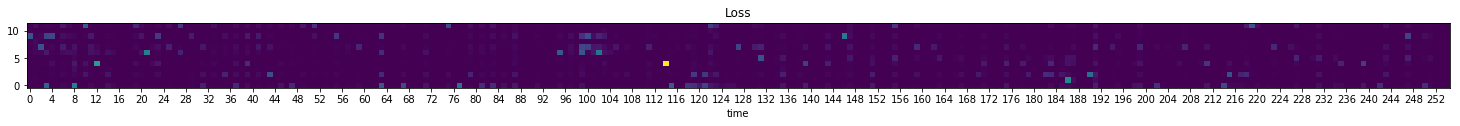

0.154017


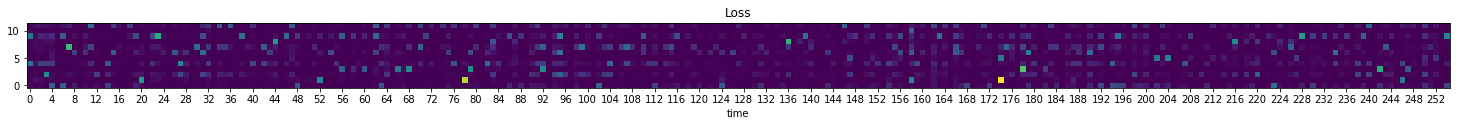

0.150895


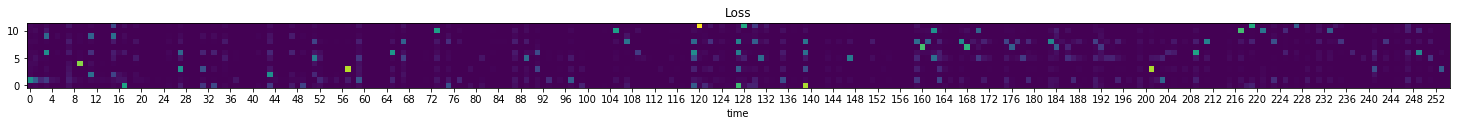

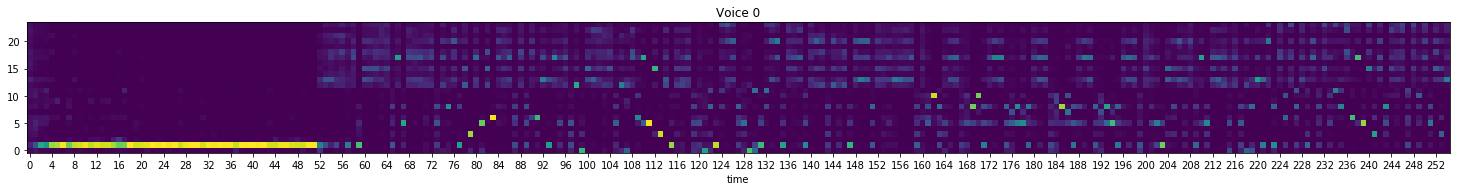

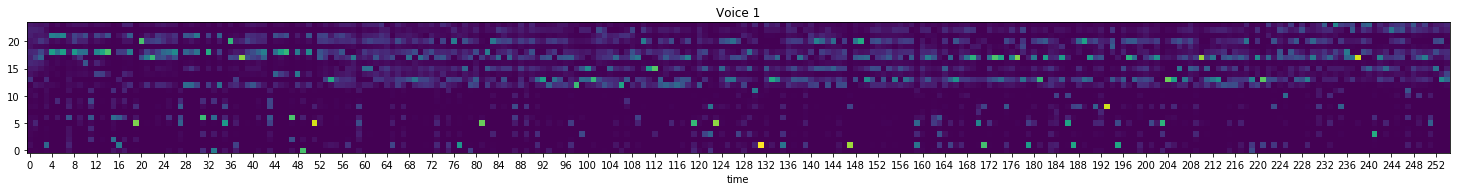

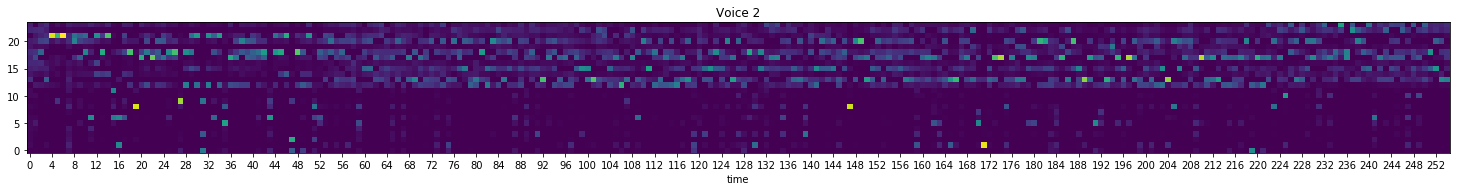

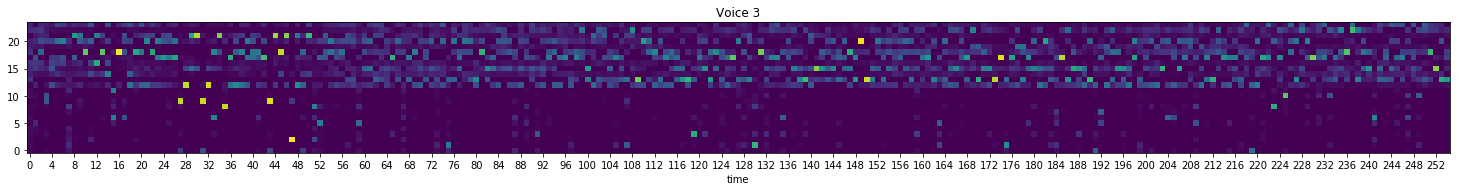

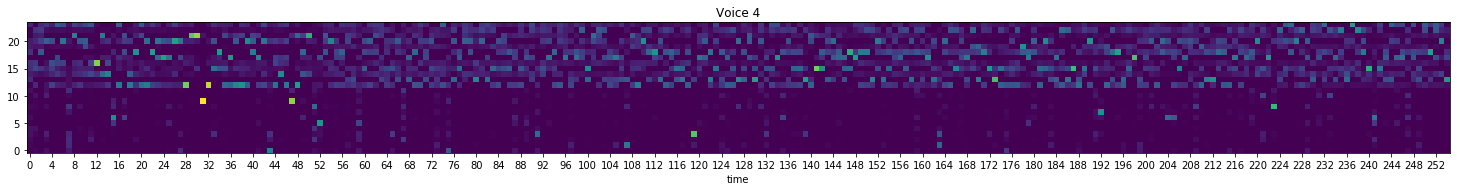

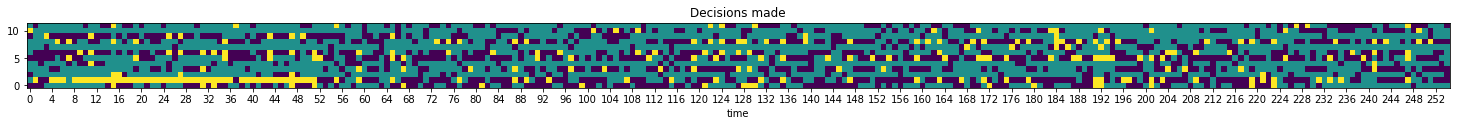

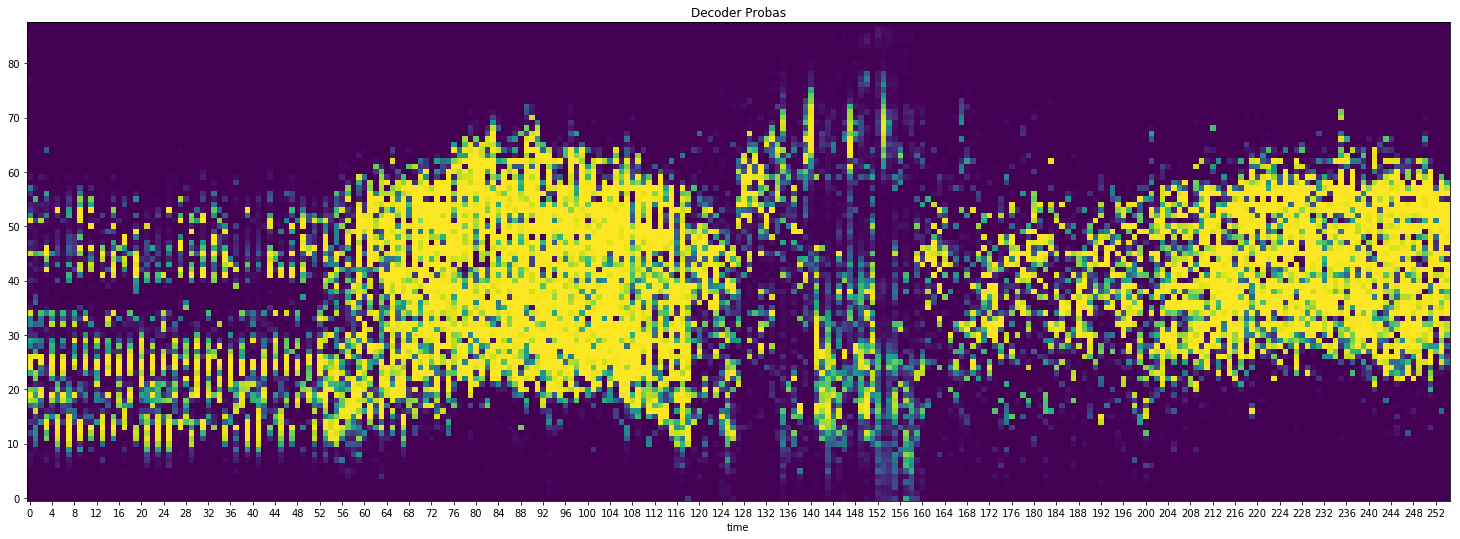

0.143567


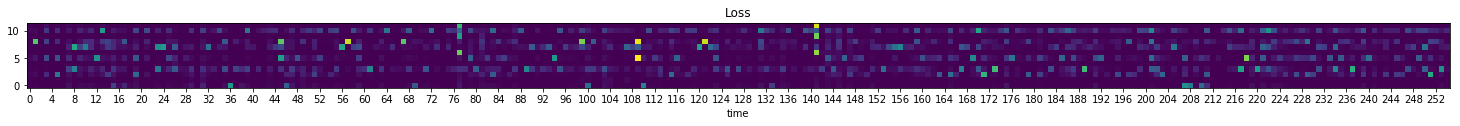

KeyboardInterrupt: 

In [141]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.003)

for batch_x, batch_decoded in batchGenerator():
    
    loss, decoder_p, voice_probas, voice_decisions = \
        learn(model, decoder, batch_x, batch_decoded, optimizer, decoder_optimizer)
           
    if len(losses) % 25 == 0:
        print(loss.mean())
        drawNotes(loss[:, 0], "Loss")
        
        if len(losses) % 100 == 0:
            decisions = np.zeros_like(voice_decisions[:, 0, 0, :12])
            for i in range(VOICES):
                drawNotes(voice_probas[:, i, 0], "Voice " + str(i))
                decisions += voice_decisions[:, i, 0, :12]
                decisions -= voice_decisions[:, i, 0, 12:]
            
            drawNotes(decisions, "Decisions made")
            
            drawNotes(decoder_p[:, 0], "Decoder Probas")
            
            if not loss.mean() is None:
                torch.save(model.state_dict(), "capsules - model.pt")
            if not decoder_p.mean() is None:
                torch.save(decoder.state_dict(), "capsules - decoder.pt")
        
    losses.append(loss.mean())
    #decoder_losses.append(decoder_loss.mean())  чё это?!?

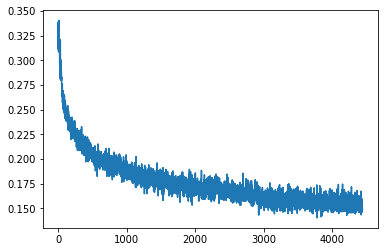

In [142]:
plt.plot(losses)
#plt.ylim([0.14, 0.19])

## Юзаем

In [171]:
from songs import *

In [185]:
n = np.random.randint(0, len(songs))
cgen, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 256)

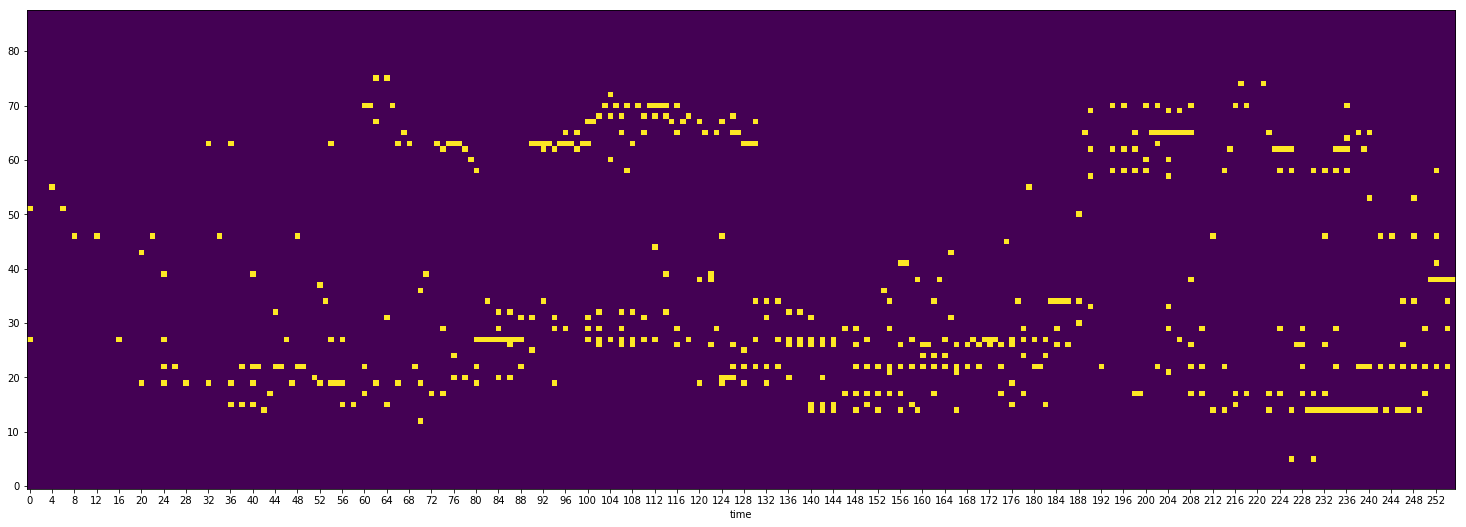

In [186]:
drawNotes(gen)

In [187]:
Song(gen, finished=True).play()

In [175]:
Song(gen, finished=True).save_file("latency lstm good example 3")

### производство часа музыки

In [110]:
final_ans = np.zeros((0, 88))
for _ in range(120):
    n = np.random.randint(0, len(songs))
    _, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 256)
    
    final_ans = np.vstack([final_ans, gen[16:], np.zeros((24, 88))])

In [112]:
final_ans = final_ans[:28760]

In [113]:
Song(final_ans, finished=True).save_file("Model with RBM decoder 1h")